In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# colormap that matplotlib can undeerstand based on the figure colors
cmap = ListedColormap(["#e68193", "#c68847", "#9e9241", "#759c40", "#43a178", "#44948e", "#4a9eb4", "#7fa0e4", "#c789e5", "#e377c5"])

## CHANGE THIS!!!!
# read csv geospatial data 
gdf = gpd.read_file('/home/sghos1/Desktop/coding_sprint/attiki_municipalities.shp')

# reproject to wgs84
gdf = gdf.to_crs(epsg=4326)



# add savings data
savings = pd.read_csv('/home/sghos1/Desktop/coding_sprint/adequacy.csv')

gdf["KWD_YPES"] = gdf["KWD_YPES"].astype(int)
savings["KWD_YPES"] = savings["KWD_YPES"].astype(int)

# join tables
merged = gdf.merge(savings, on="KWD_YPES")

In [3]:
!pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd

pd.ExcelFile('/home/sghos1/Downloads/Athens.xlsx').sheet_names

main_data = pd.read_excel('/home/sghos1/Downloads/Athens.xlsx', sheet_name='Final')


In [5]:
# create few consistent indicators such energy consumptions per households (already present)
# energy cost per household (energy cost per resident * nos of resident per buildings)
# annual income per household (already present)
main_data['Energy cost per household'] = main_data['Energy cost per residents'] * main_data['Residents per building']

# Step 4: Calculate the Energy Poverty Index (EPI)
# Formula: EPI = (Energy Cost per Resident (eur) / Average Annual Income per Household (eur)) * 100

main_data['Energy Poverty Household'] = (main_data['Energy cost per household'] / main_data['annual income per household']) * 100
main_data['Energy Poverty Threshold'] =main_data['annual income per household']*.10

main_data['Energy_Poverty_Household_s10'] = (main_data['Energy cost per household']*0.90 / main_data['annual income per household']) * 100

main_data['Energy_Poverty_improvement'] =  main_data['Energy_Poverty_Household_s10']-main_data['Energy Poverty Household']

In [6]:
# join tables
merged = gdf.merge(main_data, on="KWD_YPES")
main_data.head(5)

NAME Περιφερειακή ενότητα  KWD_YPES  buildings  Area  \
0  Dafni – Imittos      Κεντρική Αττική      9189       6040   2.4   
1     Agia Varbara        Δυτική Αττική      9179       4908   2.4   
2       Nea Smyrni         Νότια Αττική      9200       5895   3.5   
3      Filadelphia      Κεντρική Αττική      9193       3824   3.7   
4        Vrilissia        Βόρεια Αττική      9169       3595   3.9   

       Pop Dens  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh  \
0  14119.166670                     28.438429                      92.682110   
1  11149.583330                     26.721555                      27.255805   
2  20815.142860                     38.941916                     253.013508   
3   9448.108108                     25.052255                      87.689008   
4   8312.051282                     33.345475                      93.125557   

   Adequacy  Population  ...  \
0  0.306838       33886  ...   
1  0.980399       26759  ...   
2  0.153912       72853  ...   
3  0.285694       34958  ...   
4  0.358070       32417  ...   

   Energy consumption per household Mwh 4 residents  \
0                                         10.940460   
1                                          4.074264   
2                                         13.891728   
3                                         10.033641   
4                                         11.490953   

   Consumption Mwh per building  Energy cost per residents  Average  \
0                     15.344720                 272.007195  Average   
1                      5.553342                 101.296378  Average   
2                     42.920018                 345.383078  Average   
3                     22.931226                 249.461407  Average   
4                     25.904188                 285.693824  Average   

   annual income per household Energy cost per household  \
0                        32114               1526.032420   
1                        28262                552.279905   
2                        31011               4268.395828   
3                        31634               2280.510421   
4                        29857               2576.171538   

   Energy Poverty Household  Energy Poverty Threshold  \
0                  4.751923                    3211.4   
1                  1.954143                    2826.2   
2                 13.764135                    3101.1   
3                  7.209049                    3163.4   
4                  8.628367                    2985.7   

   Energy_Poverty_Household_s10  Energy_Poverty_improvement  
0                      4.276730                   -0.475192  
1                      1.758729                   -0.195414  
2                     12.387721                   -1.376413  
3                      6.488144                   -0.720905  
4                      7.765530                   -0.862837  

[5 rows x 22 columns]

In [7]:
merged["Sav_100"]=savings["S"]
merged["Sav_10"]=savings["S10"]

/tmp/ipykernel_189546/705630604.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


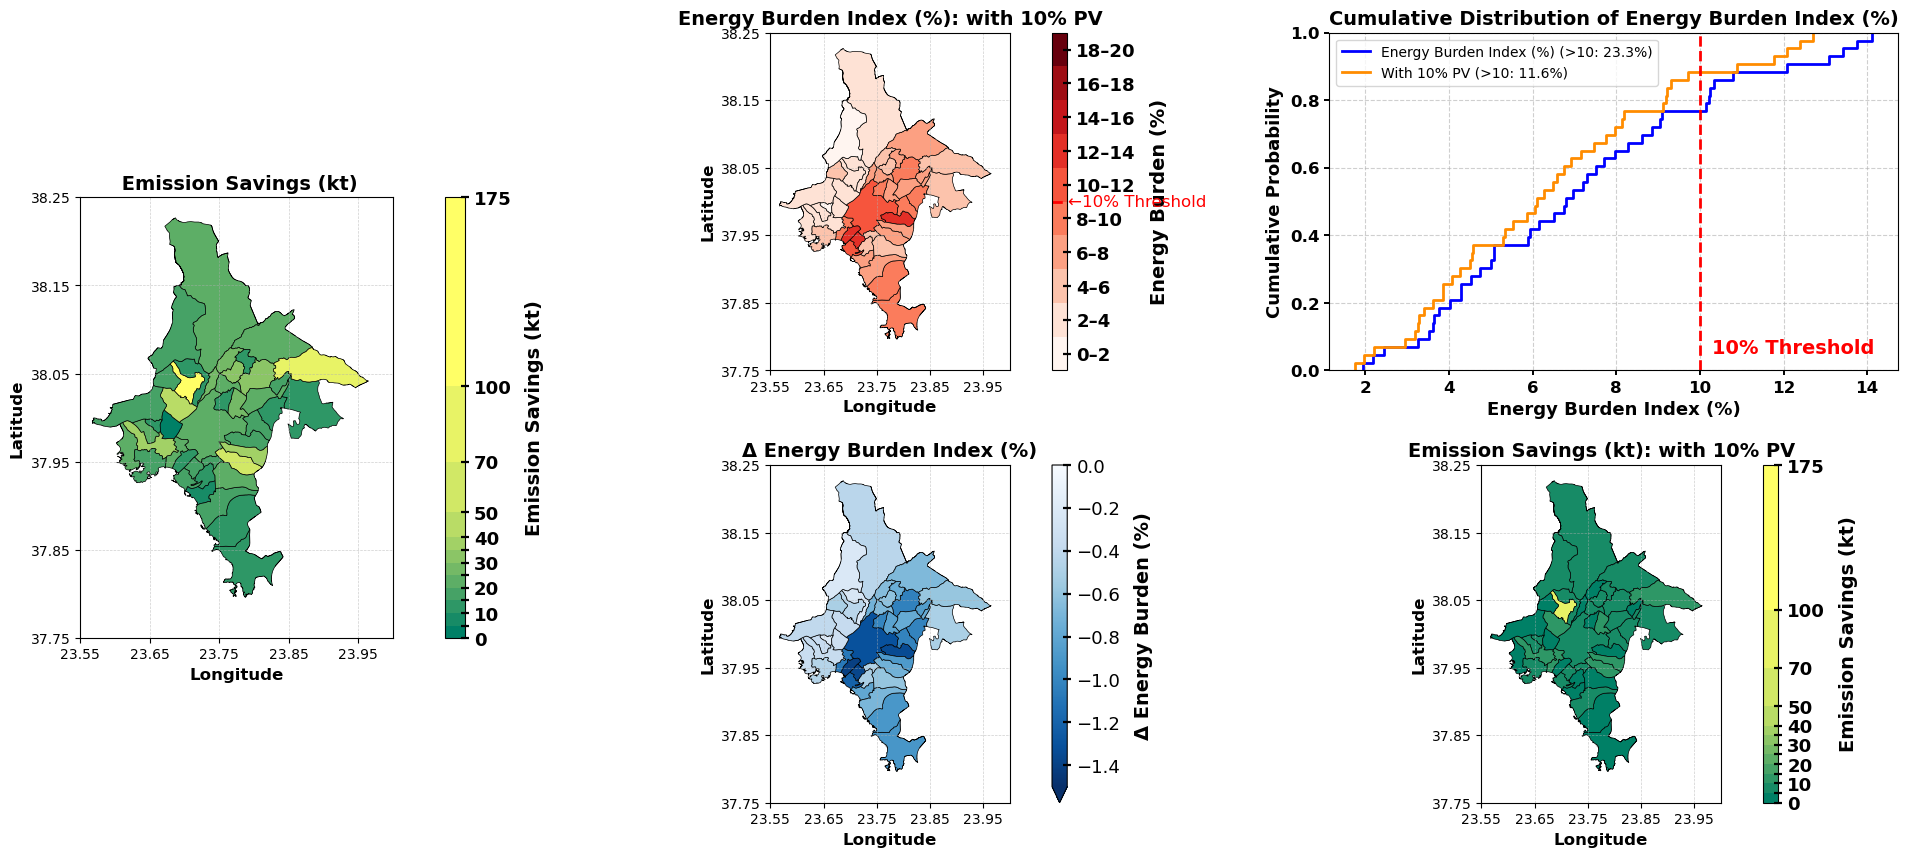

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar as cbar
import numpy as np

# -------------------------
# Common settings & helpers
# -------------------------
# CO₂ savings shared bin edges
BIN_EDGES_CO2 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 70, 100, 175]
# Energy burden bin edges (0, 2, ..., 20)
BIN_EDGES_EB = list(range(0, 22, 2))

# Fixed bounding box (Athens)
LON_MIN, LON_MAX = 23.55, 24.00
LAT_MIN, LAT_MAX = 37.75, 38.25
XTICKS = np.arange(LON_MIN, LON_MAX + 0.0001, 0.1)
YTICKS = np.arange(LAT_MIN, LAT_MAX + 0.0001, 0.1)

def add_discrete_map(
    ax, gdf, column,
    cmap_name="summer",
    bin_edges=BIN_EDGES_CO2,
    title="",
    cbar_label="",
    cbar_tick_mode="ranges",        # "ranges" (Energy Burden) or "edges" (CO₂)
    cbar_edge_labels_subset=None,   # set of edge values to label; others blank (only for "edges")
    cbar_threshold=None,            # numeric threshold to annotate on colorbar (only for "ranges")
    cbar_threshold_label=None       # text label for the threshold
):
    """Plot a GeoDataFrame column with non-uniform bins and add a proportional colorbar."""
    n_bins_local = len(bin_edges) - 1
    norm = BoundaryNorm(bin_edges, n_bins_local, clip=True)
    cmap = cm.get_cmap(cmap_name, n_bins_local)

    gdf.plot(
        column=column,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.5,
        norm=norm,
        ax=ax,
    )

    # --- Colorbar beside the axis ---
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    if cbar_tick_mode == "edges":
        cb = cbar.ColorbarBase(
            cax,
            cmap=cmap,
            norm=norm,
            boundaries=bin_edges,
            ticks=bin_edges,                # ticks at every edge
            spacing="proportional",
            orientation="vertical",
            label=cbar_label
        )
        # Sparse edge labels to avoid clutter
        if cbar_edge_labels_subset is None:
            cbar_edge_labels_subset = {0, 10, 20, 30, 40, 50, 70, 100, 175}
        ticklabels = [str(b) if b in cbar_edge_labels_subset else "" for b in bin_edges]
        cb.ax.set_yticklabels(ticklabels, fontsize=13, fontweight="bold")
        cb.ax.tick_params(width=1.6, length=6, direction="inout")

    else:  # "ranges"
        cb = cbar.ColorbarBase(
            cax,
            cmap=cmap,
            norm=norm,
            boundaries=bin_edges,
            ticks=[(a+b)/2 for a, b in zip(bin_edges[:-1], bin_edges[1:])],
            spacing="proportional",
            orientation="vertical",
            label=cbar_label
        )
        cb.ax.set_yticklabels(
            [f"{a}–{b}" for a, b in zip(bin_edges[:-1], bin_edges[1:])],
            fontsize=13, fontweight="bold"
        )
        cb.ax.tick_params(width=1.6, length=6, direction="inout")

        # --- Threshold marker on colorbar (drawn in DATA coords) ---
        if cbar_threshold is not None:
            # Draw the line at the data value (no transform kw allowed)
            cb.ax.axhline(y=cbar_threshold, color='red', linestyle='--', linewidth=2)

            # Label positioned using axes-fraction coords for robust placement
            min_val, max_val = bin_edges[0], bin_edges[-1]
            y_frac = (cbar_threshold - min_val) / (max_val - min_val)
            if cbar_threshold_label:
                cb.ax.text(
                    1.05, y_frac, cbar_threshold_label,
                    color='red', fontsize=12,
                    va='center', ha='left',
                    transform=cb.ax.transAxes
                )

    # Bold, larger colorbar label
    cb.set_label(cbar_label, fontsize=14, fontweight="bold", labelpad=10)

    # --- Axes formatting ---
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    ax.set_xlim(LON_MIN, LON_MAX)
    ax.set_ylim(LAT_MIN, LAT_MAX)
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS)

def add_continuous_map(
    ax, gdf, column,
    vmin, vmax,
    cmap_name="Blues_r",
    title="", cbar_label="", extend=None
):
    """Plot a continuous map with Normalize and add a colorbar."""
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)

    gdf.plot(
        column=column,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.5,
        vmin=vmin, vmax=vmax,
        ax=ax,
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=cax, orientation="vertical", extend=extend)

    cb.ax.tick_params(labelsize=13, width=1.6, length=6, direction="inout")
    cb.set_label(cbar_label, fontsize=14, fontweight="bold", labelpad=10)

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    ax.set_xlim(LON_MIN, LON_MAX)
    ax.set_ylim(LAT_MIN, LAT_MAX)
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS)

# -------------------------
# Figure layout
# -------------------------
fig = plt.figure(figsize=(24, 10))
outer = fig.add_gridspec(1, 2, width_ratios=[1, 3], wspace=0.18)

# Left: 1/4 width — Sav_100 (CO₂ savings, edge ticks with sparse labels)
ax_left = fig.add_subplot(outer[0, 0])
add_discrete_map(
    ax_left, merged, "Sav_100",
    cmap_name="summer",
    bin_edges=BIN_EDGES_CO2,
    title=" Emission Savings (kt)",
    cbar_label="Emission Savings (kt)",
    cbar_tick_mode="edges",
    cbar_edge_labels_subset={0, 10, 20, 30, 40, 50, 70, 100, 175}
)

# Right: 3/4 width -> 2x2 subgrid
right = outer[0, 1].subgridspec(2, 2, hspace=0.28, wspace=0.25)

# (1,1): Energy Burden with 10% PV — ranges labels + threshold marker on colorbar
ax_11 = fig.add_subplot(right[0, 0])
add_discrete_map(
    ax_11, merged, "Energy_Poverty_Household_s10",
    cmap_name="Reds",
    bin_edges=BIN_EDGES_EB,
    title="Energy Burden Index (%): with 10% PV",
    cbar_label="Energy Burden (%)",
    cbar_tick_mode="ranges",
    cbar_threshold=10,                         # draw dashed line at 10 on the colorbar
    cbar_threshold_label="←10% Threshold"      # red label next to it
)

# (1,2): CDF with bold ticks
ax_12 = fig.add_subplot(right[0, 1])
x1 = pd.to_numeric(merged["Energy Poverty Household"], errors="coerce")
x2 = pd.to_numeric(merged["Energy_Poverty_Household_s10"], errors="coerce")
x1 = x1[np.isfinite(x1)]
x2 = x2[np.isfinite(x2)]
n1 = max(x1.size, 1); n2 = max(x2.size, 1)
p1 = round((x1 > 10).sum() / n1 * 100, 1)
p2 = round((x2 > 10).sum() / n2 * 100, 1)

sns.ecdfplot(x=x1, ax=ax_12, color="blue", linewidth=2,
             label=f"Energy Burden Index (%) (>10: {p1}%)")
sns.ecdfplot(x=x2, ax=ax_12, color="darkorange", linewidth=2,
             label=f"With 10% PV (>10: {p2}%)")

ax_12.axvline(x=10, color="red", linestyle="--", linewidth=2)
ax_12.text(10.3, 0.05, "10% Threshold", color="red", fontsize=14, fontweight="bold")

ax_12.set_xlabel("Energy Burden Index (%)", fontsize=13, fontweight="bold")
ax_12.set_ylabel("Cumulative Probability", fontsize=13, fontweight="bold")
ax_12.set_title("Cumulative Distribution of Energy Burden Index (%)", fontsize=14, fontweight="bold")
ax_12.tick_params(axis='both', labelsize=12, width=1.4)
for label in ax_12.get_xticklabels() + ax_12.get_yticklabels():
    label.set_fontweight('bold')
ax_12.grid(True, linestyle="--", alpha=0.6)
ax_12.legend(fontsize=10, loc="upper left")

# (2,1): Δ Energy_Poverty_improvement (continuous)
ax_21 = fig.add_subplot(right[1, 0])
add_continuous_map(
    ax_21, merged, "Energy_Poverty_improvement",
    vmin=-1.5, vmax=0.0,
    cmap_name="Blues_r",
    title="Δ Energy Burden Index (%)",
    cbar_label="Δ Energy Burden (%)",
    extend="min"
)

# (2,2): Sav_10 — CO₂ savings, edge ticks with sparse labels
ax_22 = fig.add_subplot(right[1, 1])
add_discrete_map(
    ax_22, merged, "Sav_10",
    cmap_name="summer",
    bin_edges=BIN_EDGES_CO2,
    title="Emission Savings (kt): with 10% PV",
    cbar_label="Emission Savings (kt)",
    cbar_tick_mode="edges",
    cbar_edge_labels_subset={0, 10, 20, 30, 40, 50, 70, 100, 175}
)

plt.tight_layout()
plt.show()


In [12]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement', 'Sav_100',
       'Sav_10'],
      dtype='object')

In [26]:
import pandas as pd

# Assuming your DataFrame is named df

# Top 5 municipalities for Sav_10
top5_sav10 = merged.nlargest(5, 'PV Production Gwh – Only BBE')[['NAME_y', 'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh','Sav_10', 'Sav_100']]

# Top 5 municipalities for Sav_100
top5_sav100 = merged.nlargest(5, 'BBE SC1_100 – Consumption GWh')[['NAME_y','BBE SC1_100 – Consumption GWh','PV Production Gwh – Only BBE', 'Sav_10', 'Sav_100']]

# Total values
total_PV = merged['PV Production Gwh – Only BBE'].sum()
total_consumption = merged['BBE SC1_100 – Consumption GWh'].sum()

Adequacy_index=total_PV/total_consumption*100

# Display results
print("Top 5 municipalities for PV:")
print(top5_sav10.to_string(index=False))

print("\nTop 5 municipalities for Consumption:")
print(top5_sav100.to_string(index=False))

print(f"\nTotal PV: {total_PV:,.2f}")
print(f"Total Consumption: {total_consumption:,.2f}")

print(f"Overall Adequacy: {Adequacy_index:,.2f}")

Top 5 municipalities for PV:
                    NAME_y  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh   Sav_10   Sav_100
                    Athens                    444.906707                    2375.083641 7.605665 20.847690
                  Acharnai                    201.808400                     325.354005 8.375597 24.353707
                  Kifissia                    152.595866                     262.376612 5.405654 21.012187
Vari – Voula – Vouliagmeni                    115.273380                     289.411612 3.622584 12.971390
                   Glyfada                     93.621495                     333.456503 3.221030 10.634440

Top 5 municipalities for Consumption:
   NAME_y  BBE SC1_100 – Consumption GWh  PV Production Gwh – Only BBE    Sav_10   Sav_100
   Athens                    2375.083641                    444.906707  7.605665 20.847690
 Peiraios                     354.375390                     75.259551  8.234905 15.656469
Kallithea        

In [16]:
import pandas as pd

# Assuming your DataFrame is named df

# Top 5 municipalities for Sav_10
top5_sav10 = merged.nlargest(5, 'Sav_10')[['NAME_y', 'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh','Sav_10']]

# Top 5 municipalities for Sav_100
top5_sav100 = merged.nlargest(5, 'Sav_100')[['NAME_y','PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh', 'Sav_100']]

# Total values
total_sav10 = merged['Sav_10'].sum()
total_sav100 = merged['Sav_100'].sum()

# Display results
print("Top 5 municipalities for Sav_10:")
print(top5_sav10.to_string(index=False))

print("\nTop 5 municipalities for Sav_100:")
print(top5_sav100.to_string(index=False))

print(f"\nTotal Sav_10: {total_sav10:,.2f}")
print(f"Total Sav_100: {total_sav100:,.2f}")


Top 5 municipalities for Sav_10:
                 NAME_y  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh    Sav_10
                  Ilion                     55.805160                     211.513239 92.390754
    Filothei – Psychiko                     51.464032                     114.713522 13.785203
      Meosxato – Tauros                     34.413254                     147.926615 13.533575
             Kaisariani                     12.840888                      63.521629 13.105566
Nikaia – Agios I. Renti                     58.981672                     213.623410 12.971458

Top 5 municipalities for Sav_100:
                 NAME_y  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh    Sav_100
                  Ilion                     55.805160                     211.513239 173.068709
                Penteli                     47.271222                      92.893736  78.503468
                Vyronas                     33.979669                     

In [23]:
import pandas as pd

# Assuming your DataFrame is named df

# Compute descriptive statistics
sav100 = merged['Sav_100'].dropna()
stats = {
    'Sum': sav100.sum(),
    'Mean': sav100.mean(),
    'Median': sav100.median(),
    'Mode': sav100.mode().iloc[0] if not sav100.mode().empty else None,
    '5th Percentile': sav100.quantile(0.05),
    '95th Percentile': sav100.quantile(0.95),
    'Standard Deviation': sav100.std()
}

# Print statistics
print("📊 Statistics for Sav_100:")
for k, v in stats.items():
    print(f"{k:20s}: {v:,.2f}")

# Municipalities above the mean
above_mean = merged[merged['Sav_100'] > stats['Mean']][['NAME_y', 'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh','Sav_100']].sort_values(by='Sav_100', ascending=False)

print("\n🏙️ Municipalities above the mean Sav_100:")
print(above_mean.to_string(index=False))


📊 Statistics for Sav_100:
Sum                 : 1,102.24
Mean                : 25.63
Median              : 18.39
Mode                : 5.00
5th Percentile      : 10.42
95th Percentile     : 57.91
Standard Deviation  : 26.65

🏙️ Municipalities above the mean Sav_100:
                 NAME_y  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh    Sav_100
                  Ilion                     55.805160                     211.513239 173.068709
                Penteli                     47.271222                      92.893736  78.503468
                Vyronas                     33.979669                     140.540737  59.359792
              Peristeri                     92.609398                     336.903998  44.841345
Nikaia – Agios I. Renti                     58.981672                     213.623410  36.418762
             Kaisariani                     12.840888                      63.521629  36.025056
               Heraklio                     46.084244        

In [22]:
import pandas as pd

# Assuming your DataFrame is named df

# Compute descriptive statistics
sav100 = merged['Sav_10'].dropna()
stats = {
    'Sum': sav100.sum(),
    'Mean': sav100.mean(),
    'Median': sav100.median(),
    'Mode': sav100.mode().iloc[0] if not sav100.mode().empty else None,
    '5th Percentile': sav100.quantile(0.05),
    '95th Percentile': sav100.quantile(0.95),
    'Standard Deviation': sav100.std()
}

# Print statistics
print("📊 Statistics for Sav_10:")
for k, v in stats.items():
    print(f"{k:20s}: {v:,.2f}")

# Municipalities above the mean
above_mean = merged[merged['Sav_10'] > stats['Mean']][['NAME_y','PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh', 'Sav_10']].sort_values(by='Sav_10', ascending=False)

print("\n🏙️ Municipalities above the mean Sav_10:")
print(above_mean.to_string(index=False))


📊 Statistics for Sav_10:
Sum                 : 378.20
Mean                : 8.80
Median              : 6.15
Mode                : 1.06
5th Percentile      : 3.23
95th Percentile     : 13.49
Standard Deviation  : 13.46

🏙️ Municipalities above the mean Sav_10:
                 NAME_y  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh    Sav_10
                  Ilion                     55.805160                     211.513239 92.390754
    Filothei – Psychiko                     51.464032                     114.713522 13.785203
      Meosxato – Tauros                     34.413254                     147.926615 13.533575
             Kaisariani                     12.840888                      63.521629 13.105566
Nikaia – Agios I. Renti                     58.981672                     213.623410 12.971458
                Penteli                     47.271222                      92.893736 12.656271
              Peristeri                     92.609398                     3

In [28]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement', 'Sav_100',
       'Sav_10'],
      dtype='object')

In [33]:
import pandas as pd

# Compute descriptive statistics
sav100 = merged['Energy_Poverty_Household_s10'].dropna()
stats = {
    'Sum': sav100.sum(),
    'Mean': sav100.mean(),
    'Median': sav100.median(),
    'Mode': sav100.mode().iloc[0] if not sav100.mode().empty else None,
    '5th Percentile': sav100.quantile(0.05),
    '95th Percentile': sav100.quantile(0.95),
    'Standard Deviation': sav100.std()
}

# Print statistics
print("📊 Statistics for Energy_Poverty_Household_s10:")
for k, v in stats.items():
    print(f"{k:20s}: {v:,.2f}")

# Municipalities above 10% threshold
above_10 = merged[
    merged['Energy_Poverty_Household_s10'] > 10
][['NAME_y', 'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh', 'Sav_10']].sort_values(
    by='Sav_10', ascending=False
)

# Count of municipalities above 10% threshold
count_above_10 = len(above_10)

print("\n🏙️ Municipalities above 10% Energy_Poverty_Household_s10 threshold:")
print(above_10.to_string(index=False))
print(f"\nTotal municipalities above 10% threshold: {count_above_10}")


📊 Statistics for Energy_Poverty_Household_s10:
Sum                 : 275.67
Mean                : 6.41
Median              : 6.12
Mode                : 1.76
5th Percentile      : 2.28
95th Percentile     : 12.06
Standard Deviation  : 2.95

🏙️ Municipalities above 10% Energy_Poverty_Household_s10 threshold:
       NAME_y  PV Production Gwh – Only BBE  BBE SC1_100 – Consumption GWh   Sav_10
       Athens                    444.906707                    2375.083641 7.605665
Palaio Faliro                     40.247991                     211.694209 6.866505
   Nea Smyrni                     38.941916                     253.013508 6.154452
     Zografou                     36.238673                     195.426068 3.613566
    Kallithea                     57.175849                     347.906808 1.060251

Total municipalities above 10% threshold: 5


In [34]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement', 'Sav_100',
       'Sav_10'],
      dtype='object')

In [36]:
import pandas as pd

# Compute descriptive statistics
sav100 = merged['Area'].dropna()
stats = {
    'Sum': sav100.sum(),
    'Mean': sav100.mean(),
    'Median': sav100.median(),
    'Mode': sav100.mode().iloc[0] if not sav100.mode().empty else None,
    '5th Percentile': sav100.quantile(0.05),
    '95th Percentile': sav100.quantile(0.95),
    'Standard Deviation': sav100.std()
}

# Print statistics
print("📊 Statistics for Area0:")
for k, v in stats.items():
    print(f"{k:20s}: {v:,.2f}")

📊 Statistics for Area0:
Sum                 : 681.30
Mean                : 15.84
Median              : 7.90
Mode                : 2.40
5th Percentile      : 3.52
95th Percentile     : 38.82
Standard Deviation  : 23.02


In [37]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement', 'Sav_100',
       'Sav_10'],
      dtype='object')

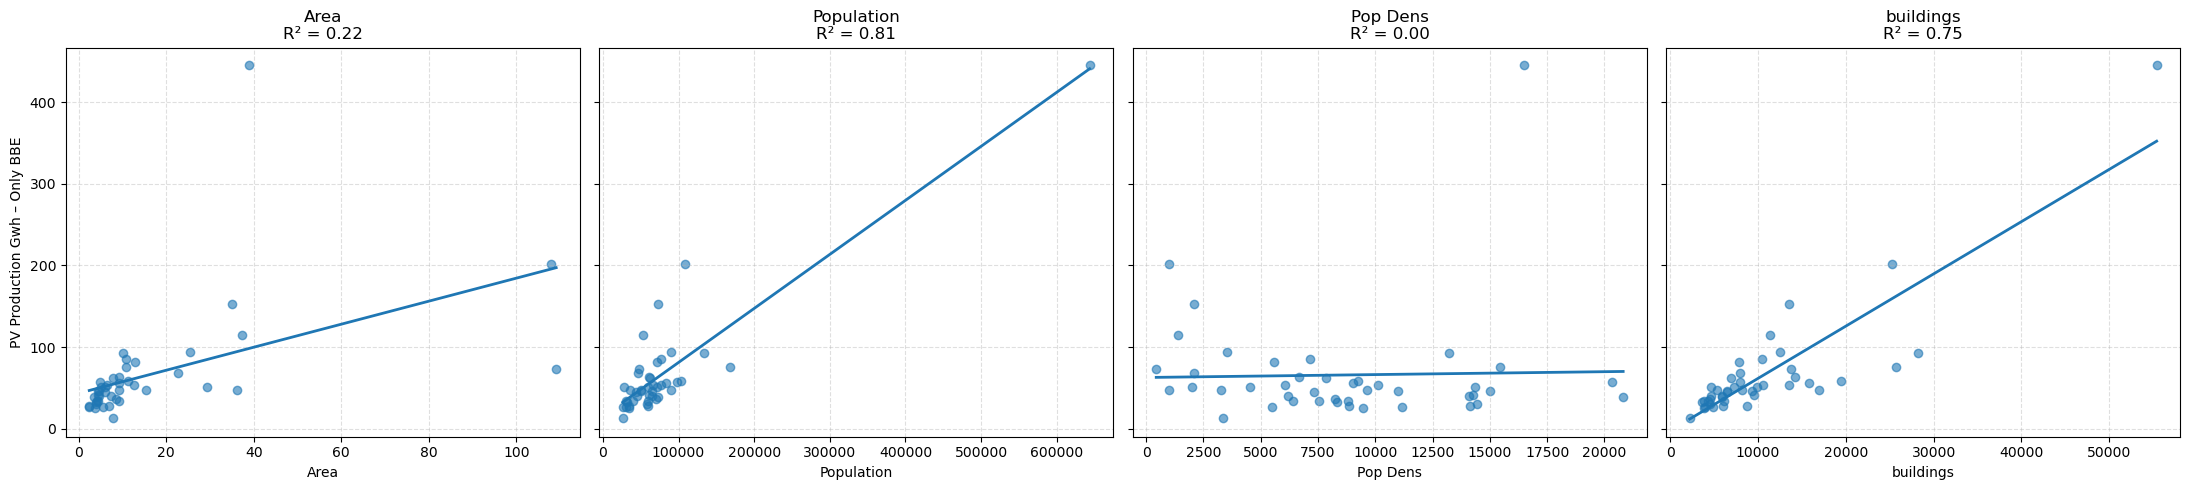

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Column names
y_col = 'PV Production Gwh – Only BBE'
x_cols = ['Area', 'Population', 'Pop Dens', 'buildings']  # mind exact spellings/case

fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharey=True)

for ax, x_col in zip(axes, x_cols):
    # Keep only numeric rows for these two columns
    data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    if len(x) < 2:
        ax.set_title(f"{x_col}\nR² = N/A")
        ax.set_xlabel(x_col)
        if ax is axes[0]:
            ax.set_ylabel(y_col)
        ax.grid(True, linestyle='--', alpha=0.4)
        continue

    # Fit y = m*x + b
    m, b = np.polyfit(x, y, 1)

    # Predicted values and R²
    y_pred = m * x + b
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # Scatter
    ax.scatter(x, y, alpha=0.6)

    # Regression line (sorted x for a clean line)
    order = np.argsort(x)
    ax.plot(x[order], y_pred[order], linewidth=2)

    # Labels
    ax.set_title(f"{x_col}\nR² = {r2:.2f}")
    ax.set_xlabel(x_col)
    if ax is axes[0]:
        ax.set_ylabel(y_col)

    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


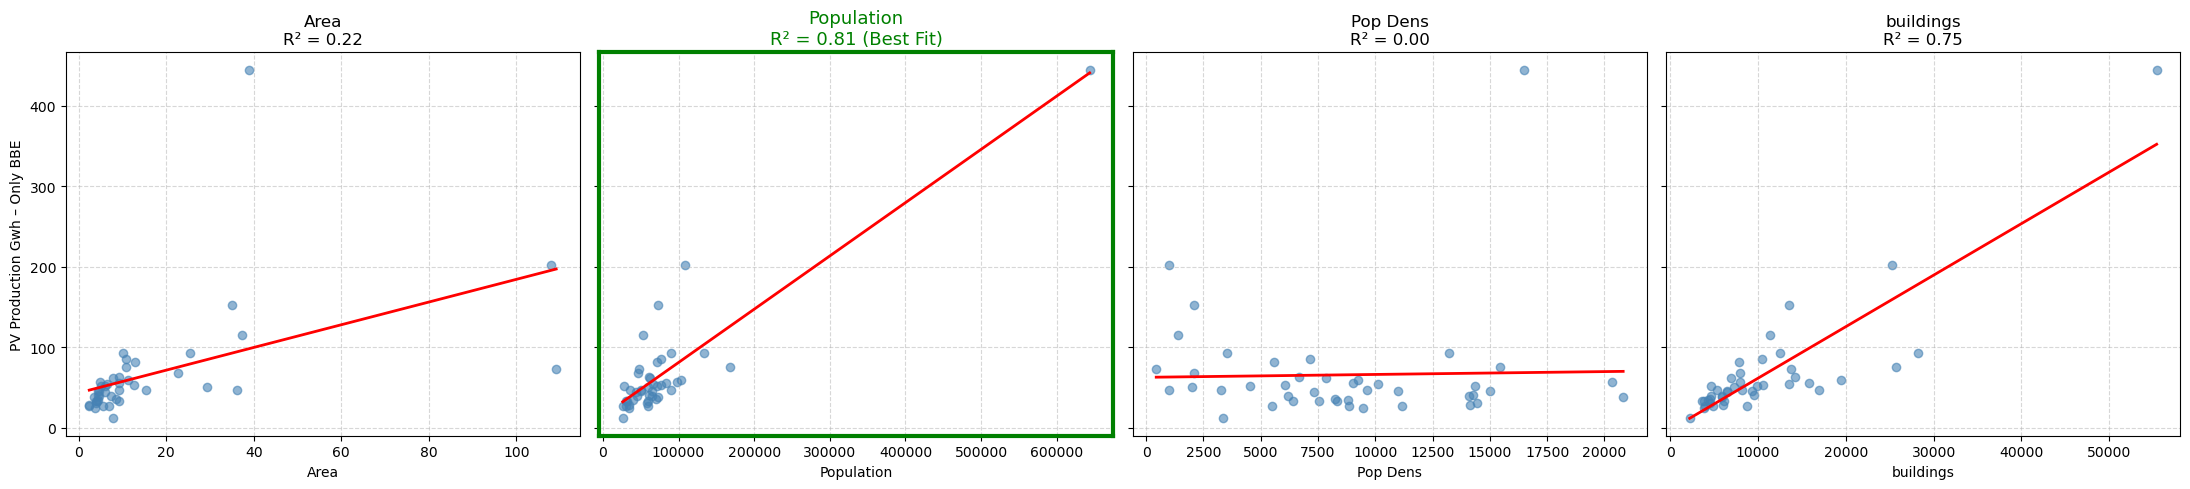

📈 R² values for each variable:
Area           : 0.224
Population     : 0.808
Pop Dens       : 0.001
buildings      : 0.753

✅ Best fit: Population (R² = 0.808)


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
y_col = 'PV Production Gwh – Only BBE'
x_cols = ['Area', 'Population', 'Pop Dens', 'buildings']

# Prepare
r2_dict = {}

fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharey=True)

for ax, x_col in zip(axes, x_cols):
    data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    # Fit linear model
    m, b = np.polyfit(x, y, 1)
    y_pred = m * x + b

    # R²
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    r2_dict[x_col] = r2

    # Scatter + regression line
    ax.scatter(x, y, alpha=0.6, color='steelblue')
    order = np.argsort(x)
    ax.plot(x[order], y_pred[order], color='red', linewidth=2)

    ax.set_title(f"{x_col}\nR² = {r2:.2f}")
    ax.set_xlabel(x_col)
    if ax is axes[0]:
        ax.set_ylabel(y_col)
    ax.grid(True, linestyle='--', alpha=0.5)

# Identify best-fit variable
best_var = max(r2_dict, key=r2_dict.get)
best_r2 = r2_dict[best_var]

# Highlight best subplot
for ax, x_col in zip(axes, x_cols):
    if x_col == best_var:
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(3)
        ax.set_title(f"{x_col}\nR² = {best_r2:.2f} (Best Fit)", color='green', fontsize=13)

plt.tight_layout()
plt.show()

# Print R² values
print("📈 R² values for each variable:")
for k, v in r2_dict.items():
    print(f"{k:15s}: {v:.3f}")

print(f"\n✅ Best fit: {best_var} (R² = {best_r2:.3f})")


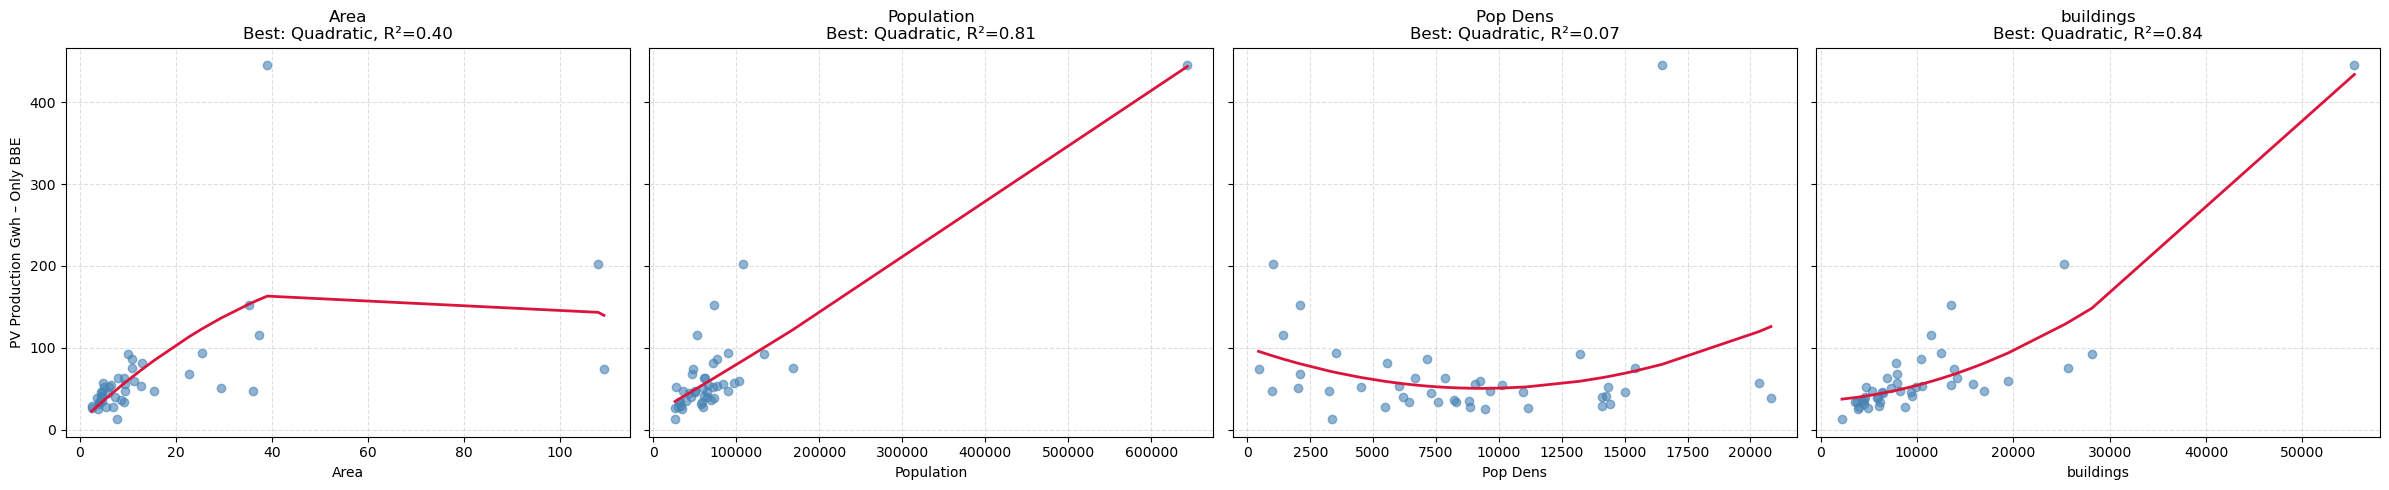

📊 Best fit model for each variable:
Area           : Quadratic    (R² = 0.396)
Population     : Quadratic    (R² = 0.809)
Pop Dens       : Quadratic    (R² = 0.070)
buildings      : Quadratic    (R² = 0.839)


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_col = 'PV Production Gwh – Only BBE'
x_cols = ['Area', 'Population', 'Pop Dens', 'buildings']

def compute_r2(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)
results = {}

for ax, x_col in zip(axes, x_cols):
    data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    forms = {}
    # 1️⃣ Linear
    p = np.polyfit(x, y, 1)
    y_pred = np.polyval(p, x)
    forms['Linear'] = compute_r2(y, y_pred)

    # 2️⃣ Logarithmic (x>0)
    if np.all(x > 0):
        p = np.polyfit(np.log(x), y, 1)
        y_pred = np.polyval(p, np.log(x))
        forms['Logarithmic'] = compute_r2(y, y_pred)

    # 3️⃣ Exponential (y>0)
    if np.all(y > 0):
        p = np.polyfit(x, np.log(y), 1)
        y_pred = np.exp(np.polyval(p, x))
        forms['Exponential'] = compute_r2(y, y_pred)

    # 4️⃣ Quadratic
    p = np.polyfit(x, y, 2)
    y_pred = np.polyval(p, x)
    forms['Quadratic'] = compute_r2(y, y_pred)

    # Find best
    best_form = max(forms, key=forms.get)
    best_r2 = forms[best_form]
    results[x_col] = (best_form, best_r2)

    # Recompute prediction for plotting
    if best_form == 'Linear':
        p = np.polyfit(x, y, 1)
        y_pred = np.polyval(p, x)
    elif best_form == 'Logarithmic':
        p = np.polyfit(np.log(x), y, 1)
        y_pred = np.polyval(p, np.log(x))
    elif best_form == 'Exponential':
        p = np.polyfit(x, np.log(y), 1)
        y_pred = np.exp(np.polyval(p, x))
    elif best_form == 'Quadratic':
        p = np.polyfit(x, y, 2)
        y_pred = np.polyval(p, x)

    # Plot scatter and fitted curve
    order = np.argsort(x)
    ax.scatter(x, y, alpha=0.6, color='steelblue')
    ax.plot(x[order], y_pred[order], color='crimson', linewidth=2)
    ax.set_title(f"{x_col}\nBest: {best_form}, R²={best_r2:.2f}")
    ax.set_xlabel(x_col)
    if ax is axes[0]:
        ax.set_ylabel(y_col)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Print summary
print("📊 Best fit model for each variable:")
for k, (form, r2) in results.items():
    print(f"{k:15s}: {form:12s} (R² = {r2:.3f})")


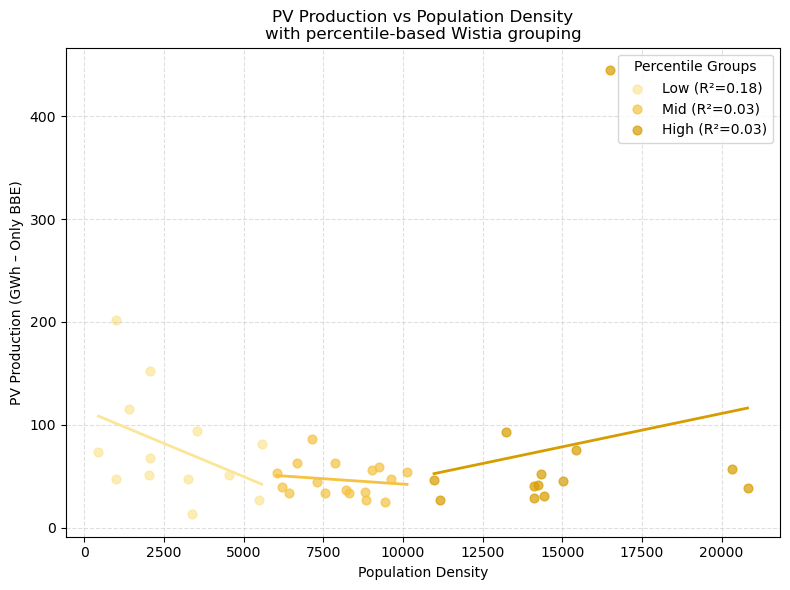

📊 R² by Population Density group:
Low   : 0.176
Mid   : 0.028
High  : 0.029


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare and clean data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Define percentile thresholds
p1 = np.percentile(x, 30)
p2 = np.percentile(x, 70)

# Define Wistia color shades
colors = {
    'Low': to_rgba('#fbe698'),   # light Wistia tone
    'Mid': to_rgba('#f5c242'),   # mid Wistia tone
    'High': to_rgba('#d79d00')   # dark Wistia tone
}

groups = {
    'Low': (x <= p1),
    'Mid': (x > p1) & (x <= p2),
    'High': (x > p2)
}

fig, ax = plt.subplots(figsize=(8, 6))
r2_results = {}

for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 2:
        continue

    # Fit linear regression (best for small bins)
    coeff = np.polyfit(xg, yg, 1)
    y_pred = np.polyval(coeff, xg)

    # R²
    ss_res = np.sum((yg - y_pred)**2)
    ss_tot = np.sum((yg - np.mean(yg))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    r2_results[label] = r2

    # Scatter + regression line
    ax.scatter(xg, yg, color=colors[label], label=f"{label} (R²={r2:.2f})", alpha=0.7, s=40)
    order = np.argsort(xg)
    ax.plot(xg[order], y_pred[order], color=colors[label], linewidth=2)

# Labels and layout
ax.set_xlabel('Population Density')
ax.set_ylabel('PV Production (GWh – Only BBE)')
ax.set_title('PV Production vs Population Density\nwith percentile-based Wistia grouping')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Percentile Groups', frameon=True)

plt.tight_layout()
plt.show()

# Print R² summary
print("📊 R² by Population Density group:")
for g, r2 in r2_results.items():
    print(f"{g:6s}: {r2:.3f}")


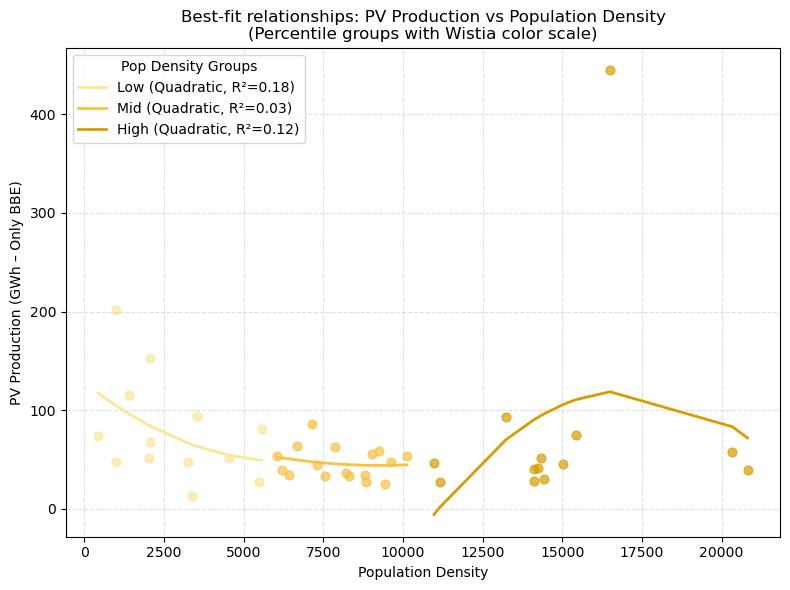

📊 Best-fit model per Population Density group:
Low   : Quadratic    (R² = 0.185)
Mid   : Quadratic    (R² = 0.033)
High  : Quadratic    (R² = 0.118)


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Define columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile thresholds
p1 = np.percentile(x, 30)
p2 = np.percentile(x, 70)

# Define Wistia palette
colors = {
    'Low': to_rgba('#fbe698'),   # light
    'Mid': to_rgba('#f5c242'),   # medium
    'High': to_rgba('#d79d00')   # dark
}

# Groups based on population density percentiles
groups = {
    'Low': (x <= p1),
    'Mid': (x > p1) & (x <= p2),
    'High': (x > p2)
}

def compute_r2(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
results = {}

for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    forms = {}
    # 1️⃣ Linear
    p = np.polyfit(xg, yg, 1)
    y_pred = np.polyval(p, xg)
    forms['Linear'] = compute_r2(yg, y_pred)

    # 2️⃣ Logarithmic (x>0)
    if np.all(xg > 0):
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
        forms['Logarithmic'] = compute_r2(yg, y_pred)

    # 3️⃣ Exponential (y>0)
    if np.all(yg > 0):
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
        forms['Exponential'] = compute_r2(yg, y_pred)

    # 4️⃣ Quadratic
    p = np.polyfit(xg, yg, 2)
    y_pred = np.polyval(p, xg)
    forms['Quadratic'] = compute_r2(yg, y_pred)

    # Select best form
    best_form = max(forms, key=forms.get)
    best_r2 = forms[best_form]
    results[label] = (best_form, best_r2)

    # Refit for best form
    if best_form == 'Linear':
        p = np.polyfit(xg, yg, 1)
        y_pred = np.polyval(p, xg)
    elif best_form == 'Logarithmic':
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
    elif best_form == 'Exponential':
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
    elif best_form == 'Quadratic':
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)

    # Scatter and best-fit curve
    ax.scatter(xg, yg, color=colors[label], alpha=0.7, s=40)
    order = np.argsort(xg)
    ax.plot(xg[order], y_pred[order], color=colors[label], linewidth=2,
            label=f"{label} ({best_form}, R²={best_r2:.2f})")

# Aesthetics
ax.set_xlabel('Population Density')
ax.set_ylabel('PV Production (GWh – Only BBE)')
ax.set_title('Best-fit relationships: PV Production vs Population Density\n(Percentile groups with Wistia color scale)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Pop Density Groups', frameon=True)

plt.tight_layout()
plt.show()

# Print summary in console
print("📊 Best-fit model per Population Density group:")
for g, (form, r2) in results.items():
    print(f"{g:6s}: {form:12s} (R² = {r2:.3f})")


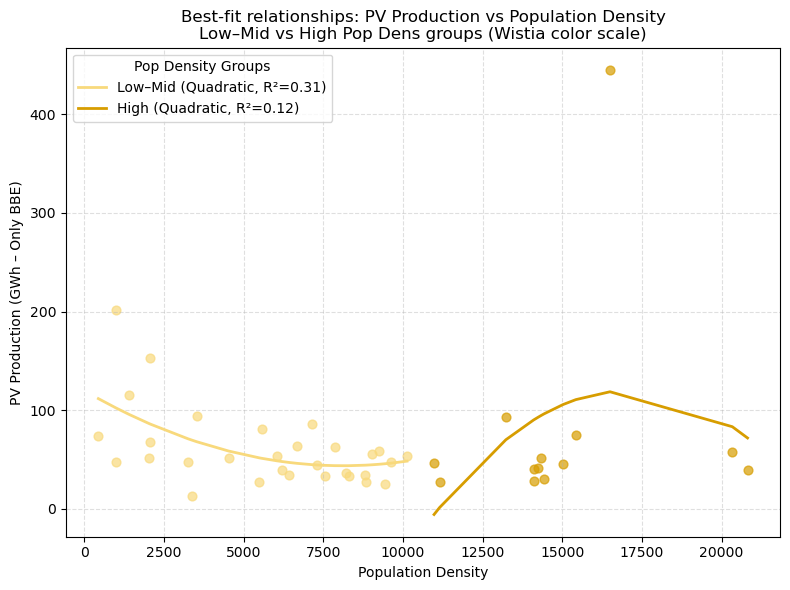

📊 Best-fit model per Population Density group:
Low–Mid : Quadratic    (R² = 0.306)
High    : Quadratic    (R² = 0.118)


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile threshold
p2 = np.percentile(x, 70)  # 70th percentile cutoff

# Wistia-inspired colors
colors = {
    'Low–Mid': to_rgba('#f8d97c'),  # light golden
    'High': to_rgba('#d79d00')      # darker amber
}

# Two groups
groups = {
    'Low–Mid': (x <= p2),
    'High': (x > p2)
}

def compute_r2(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
results = {}

for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    forms = {}
    # 1️⃣ Linear
    p = np.polyfit(xg, yg, 1)
    y_pred = np.polyval(p, xg)
    forms['Linear'] = compute_r2(yg, y_pred)

    # 2️⃣ Logarithmic (x>0)
    if np.all(xg > 0):
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
        forms['Logarithmic'] = compute_r2(yg, y_pred)

    # 3️⃣ Exponential (y>0)
    if np.all(yg > 0):
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
        forms['Exponential'] = compute_r2(yg, y_pred)

    # 4️⃣ Quadratic
    p = np.polyfit(xg, yg, 2)
    y_pred = np.polyval(p, xg)
    forms['Quadratic'] = compute_r2(yg, y_pred)

    # Select best form
    best_form = max(forms, key=forms.get)
    best_r2 = forms[best_form]
    results[label] = (best_form, best_r2)

    # Refit for best form
    if best_form == 'Linear':
        p = np.polyfit(xg, yg, 1)
        y_pred = np.polyval(p, xg)
    elif best_form == 'Logarithmic':
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
    elif best_form == 'Exponential':
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
    elif best_form == 'Quadratic':
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)

    # Scatter and fit
    ax.scatter(xg, yg, color=colors[label], alpha=0.7, s=40)
    order = np.argsort(xg)
    ax.plot(xg[order], y_pred[order], color=colors[label], linewidth=2,
            label=f"{label} ({best_form}, R²={best_r2:.2f})")

# Labels and legend
ax.set_xlabel('Population Density')
ax.set_ylabel('PV Production (GWh – Only BBE)')
ax.set_title('Best-fit relationships: PV Production vs Population Density\nLow–Mid vs High Pop Dens groups (Wistia color scale)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Pop Density Groups', frameon=True)

plt.tight_layout()
plt.show()

# Print summary
print("📊 Best-fit model per Population Density group:")
for g, (form, r2) in results.items():
    print(f"{g:8s}: {form:12s} (R² = {r2:.3f})")


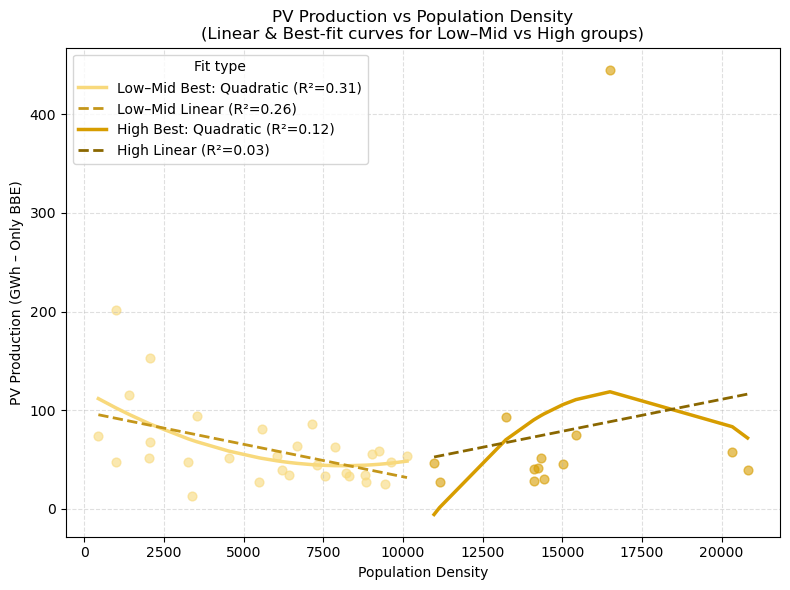

📊 R² summary:
Low–Mid : Linear R²=0.260, Best=Quadratic (R²=0.306)
High    : Linear R²=0.029, Best=Quadratic (R²=0.118)


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile threshold
p70 = np.percentile(x, 70)

# Define colors (Wistia-inspired)
colors = {
    'Low–Mid': to_rgba('#f8d97c'),  # light golden
    'High': to_rgba('#d79d00')      # dark amber
}
lin_colors = {
    'Low–Mid': '#c4961a',
    'High': '#8a6700'
}

# Group masks
groups = {
    'Low–Mid': (x <= p70),
    'High': (x > p70)
}

def compute_r2(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
results = {}

for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- 1️⃣ Linear fit ---
    pl = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(pl, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- 2️⃣ Test all fits and find best ---
    forms = {'Linear': r2_lin}

    # Logarithmic (x>0)
    if np.all(xg > 0):
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
        forms['Logarithmic'] = compute_r2(yg, y_pred)

    # Exponential (y>0)
    if np.all(yg > 0):
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
        forms['Exponential'] = compute_r2(yg, y_pred)

    # Quadratic
    p = np.polyfit(xg, yg, 2)
    y_pred = np.polyval(p, xg)
    forms['Quadratic'] = compute_r2(yg, y_pred)

    # Find best form
    best_form = max(forms, key=forms.get)
    best_r2 = forms[best_form]
    results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

    # --- Compute y_best for plotting ---
    if best_form == 'Linear':
        y_best = y_lin
    elif best_form == 'Logarithmic':
        p = np.polyfit(np.log(xg), yg, 1)
        y_best = np.polyval(p, np.log(xg))
    elif best_form == 'Exponential':
        p = np.polyfit(xg, np.log(yg), 1)
        y_best = np.exp(np.polyval(p, xg))
    elif best_form == 'Quadratic':
        p = np.polyfit(xg, yg, 2)
        y_best = np.polyval(p, xg)

    # --- Plot ---
    order = np.argsort(xg)
    ax.scatter(xg, yg, color=colors[label], alpha=0.6, s=40)

    # Best-fit curve
    ax.plot(xg[order], y_best[order], color=colors[label], linewidth=2.5,
            label=f"{label} Best: {best_form} (R²={best_r2:.2f})")

    # Linear line (darker tone)
    ax.plot(xg[order], y_lin[order], color=lin_colors[label], linestyle='--', linewidth=2,
            label=f"{label} Linear (R²={r2_lin:.2f})")

# --- Aesthetics ---
ax.set_xlabel('Population Density')
ax.set_ylabel('PV Production (GWh – Only BBE)')
ax.set_title('PV Production vs Population Density\n(Linear & Best-fit curves for Low–Mid vs High groups)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fit type', frameon=True)

plt.tight_layout()
plt.show()

# --- Print summary ---
print("📊 R² summary:")
for g, vals in results.items():
    print(f"{g:8s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")


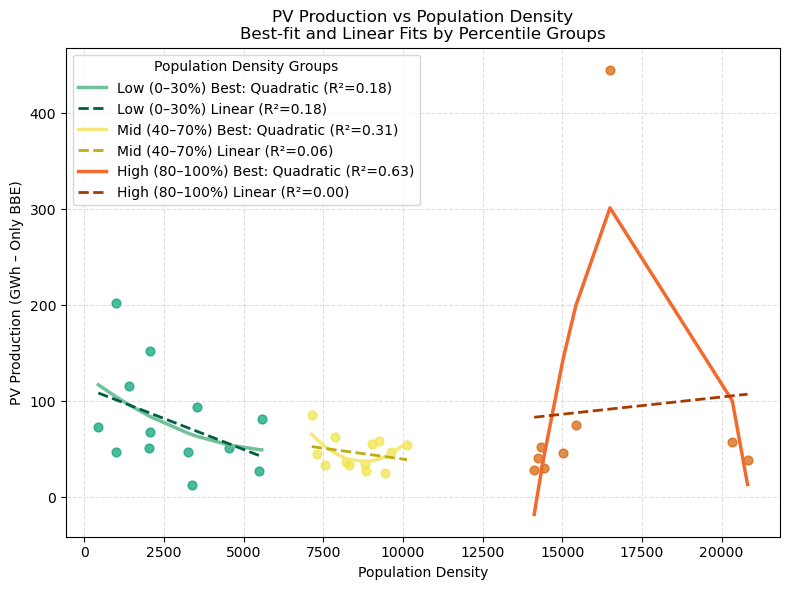

📊 R² Summary:
Low (0–30%)   : Linear R²=0.176, Best=Quadratic (R²=0.185)
Mid (40–70%)  : Linear R²=0.061, Best=Quadratic (R²=0.307)
High (80–100%): Linear R²=0.005, Best=Quadratic (R²=0.634)


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Define scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',   # Green
    'Mid (40–70%)': '#f0e442',  # Yellow
    'High (80–100%)': '#d55e00' # Red
}

# Group masks
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

# Regression line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b',
    'High (80–100%)': '#f26a2e'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
results = {}

for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # ---- Linear fit ----
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # ---- Test best-fit models ----
    forms = {'Linear': r2_lin}

    # Logarithmic (x>0)
    if np.all(xg > 0):
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
        forms['Logarithmic'] = compute_r2(yg, y_pred)

    # Exponential (y>0)
    if np.all(yg > 0):
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
        forms['Exponential'] = compute_r2(yg, y_pred)

    # Quadratic
    p = np.polyfit(xg, yg, 2)
    y_pred = np.polyval(p, xg)
    forms['Quadratic'] = compute_r2(yg, y_pred)

    # ---- Best model ----
    best_form = max(forms, key=forms.get)
    best_r2 = forms[best_form]
    results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

    # Compute y_best
    if best_form == 'Linear':
        y_best = y_lin
    elif best_form == 'Logarithmic':
        p = np.polyfit(np.log(xg), yg, 1)
        y_best = np.polyval(p, np.log(xg))
    elif best_form == 'Exponential':
        p = np.polyfit(xg, np.log(yg), 1)
        y_best = np.exp(np.polyval(p, xg))
    else:  # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_best = np.polyval(p, xg)

    # ---- Plot ----
    order = np.argsort(xg)

    # Scatter
    ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.7, s=40)

    # Best-fit (solid)
    ax.plot(xg[order], y_best[order],
            color=line_colors_best[label], linewidth=2.5,
            label=f"{label} Best: {best_form} (R²={best_r2:.2f})")

    # Linear (dashed)
    ax.plot(xg[order], y_lin[order],
            color=line_colors_lin[label], linestyle='--', linewidth=2,
            label=f"{label} Linear (R²={r2_lin:.2f})")

# ---- Aesthetics ----
ax.set_xlabel('Population Density')
ax.set_ylabel('PV Production (GWh – Only BBE)')
ax.set_title('PV Production vs Population Density\nBest-fit and Linear Fits by Percentile Groups')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Population Density Groups', frameon=True)

plt.tight_layout()
plt.show()

# ---- Print Summary ----
print("📊 R² Summary:")
for g, vals in results.items():
    print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")


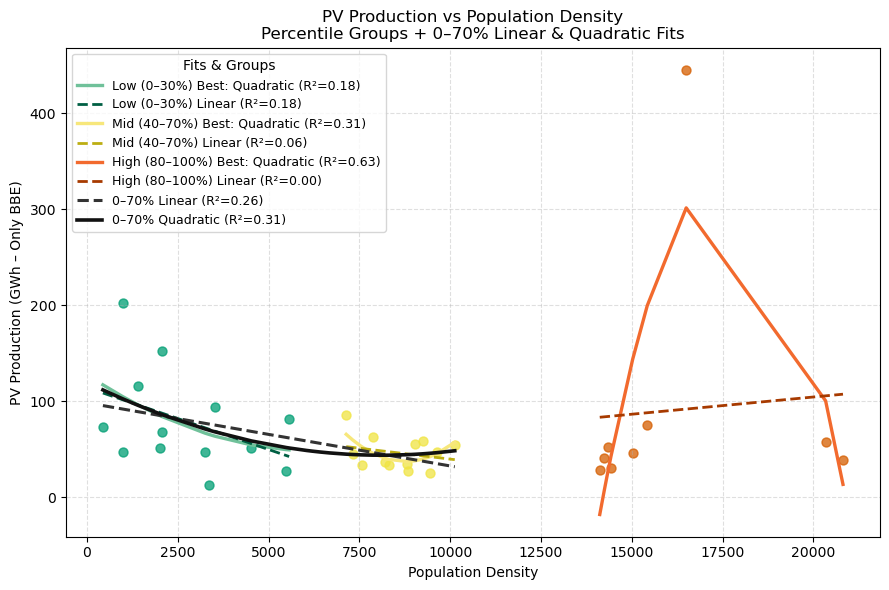

📊 R² Summary (per group):
Low (0–30%)   : Linear R²=0.176, Best=Quadratic (R²=0.185)
Mid (40–70%)  : Linear R²=0.061, Best=Quadratic (R²=0.307)
High (80–100%): Linear R²=0.005, Best=Quadratic (R²=0.634)

0–70% aggregate fits: Linear R²=0.260, Quadratic R²=0.306


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors (as requested)
scatter_colors = {
    'Low (0–30%)':  '#009e73',  # green
    'Mid (40–70%)': '#f0e442',  # yellow
    'High (80–100%)': '#d55e00' # red
}

# Regression line colors for per-group fits (best + linear)
line_colors_best = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b',
    'High (80–100%)': '#f26a2e'
}
line_colors_lin = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Group masks (note gaps 30–40 and 70–80 are intentionally excluded from the 3-band scatter)
groups = {
    'Low (0–30%)':      (x <= p30),
    'Mid (40–70%)':     (x > p40) & (x <= p70),
    'High (80–100%)':   (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups with linear + best-fit ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # Linear
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # Best among linear, log, exp, quadratic
    forms = {'Linear': r2_lin}

    # Logarithmic (x>0)
    if np.all(xg > 0):
        p = np.polyfit(np.log(xg), yg, 1)
        y_pred = np.polyval(p, np.log(xg))
        forms['Logarithmic'] = compute_r2(yg, y_pred)

    # Exponential (y>0)
    if np.all(yg > 0):
        p = np.polyfit(xg, np.log(yg), 1)
        y_pred = np.exp(np.polyval(p, xg))
        forms['Exponential'] = compute_r2(yg, y_pred)

    # Quadratic
    p = np.polyfit(xg, yg, 2)
    y_quad = np.polyval(p, xg)
    forms['Quadratic'] = compute_r2(yg, y_quad)

    best_form = max(forms, key=forms.get)
    best_r2 = forms[best_form]
    results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

    # Compute best-fit curve y_best
    if best_form == 'Linear':
        y_best = y_lin
    elif best_form == 'Logarithmic':
        p = np.polyfit(np.log(xg), yg, 1)
        y_best = np.polyval(p, np.log(xg))
    elif best_form == 'Exponential':
        p = np.polyfit(xg, np.log(yg), 1)
        y_best = np.exp(np.polyval(p, xg))
    else:  # Quadratic
        y_best = y_quad

    # Plot scatter
    ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)

    # Plot best-fit (solid) and linear (dashed)
    order = np.argsort(xg)
    ax.plot(xg[order], y_best[order],
            color=line_colors_best[label], linewidth=2.4,
            label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
    ax.plot(xg[order], y_lin[order],
            color=line_colors_lin[label], linestyle='--', linewidth=2,
            label=f"{label} Linear (R²={r2_lin:.2f})")

# --------- EXTRA: Fits over the entire 0–70% range (both Linear & Quadratic) ----------
mask_0_70 = (x <= p70)  # includes all data up to the 70th percentile (also covers the 30–40 band)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear over 0–70%
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic over 0–70%
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)

    # Use neutral tones for these aggregate lines
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Population Density')
ax.set_ylabel('PV Production (GWh – Only BBE)')
ax.set_title('PV Production vs Population Density\nPercentile Groups + 0–70% Linear & Quadratic Fits')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary (per group):")
for g, vals in results.items():
    print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")


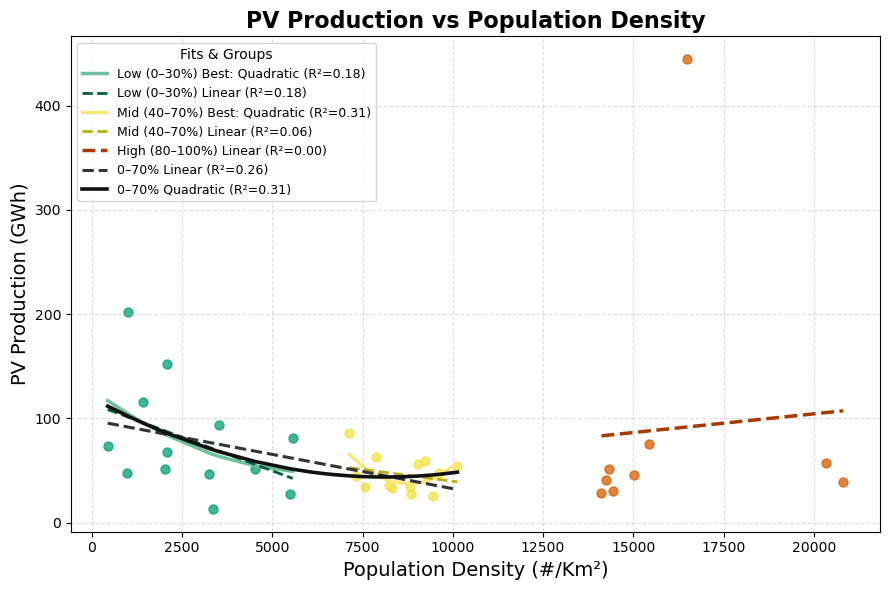

📊 R² Summary:
Low (0–30%)   : Linear R²=0.176, Best=Quadratic (R²=0.185)
Mid (40–70%)  : Linear R²=0.061, Best=Quadratic (R²=0.307)
High (80–100%): Linear R²=0.005

0–70% aggregate fits: Linear R²=0.260, Quadratic R²=0.306


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Pop Dens'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Population Density (#/Km²)',  fontsize=14)
ax.set_ylabel('PV Production (GWh)', fontsize=14)
ax.set_title('PV Production vs Population Density', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")


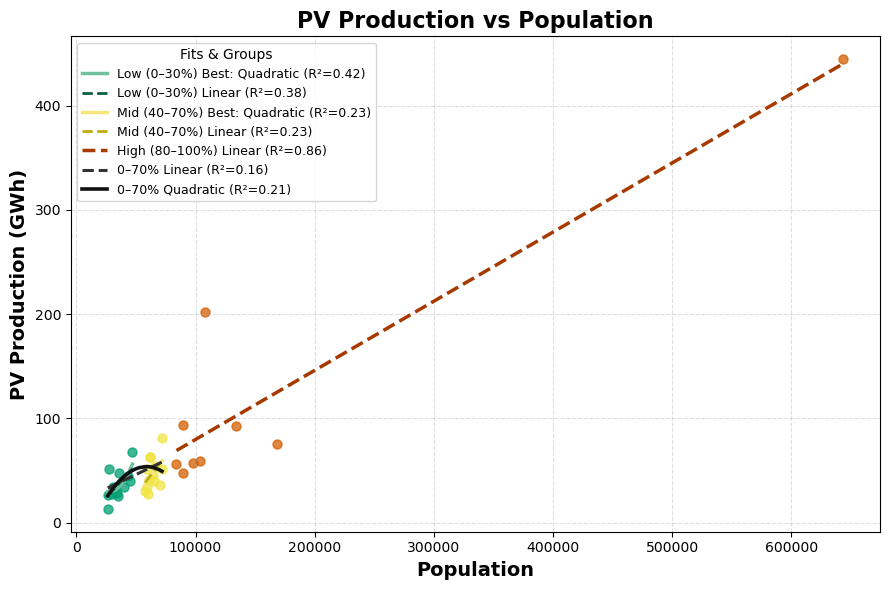

📊 R² Summary:
Low (0–30%)   : Linear R²=0.381, Best=Quadratic (R²=0.424)
Mid (40–70%)  : Linear R²=0.227, Best=Quadratic (R²=0.229)
High (80–100%): Linear R²=0.861

0–70% aggregate fits: Linear R²=0.158, Quadratic R²=0.209


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Population'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups (note: 30–40 and 70–80 intentionally excluded)
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Population', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Production (GWh)', fontsize=14, fontweight='bold')
ax.set_title('PV Production vs Population', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")


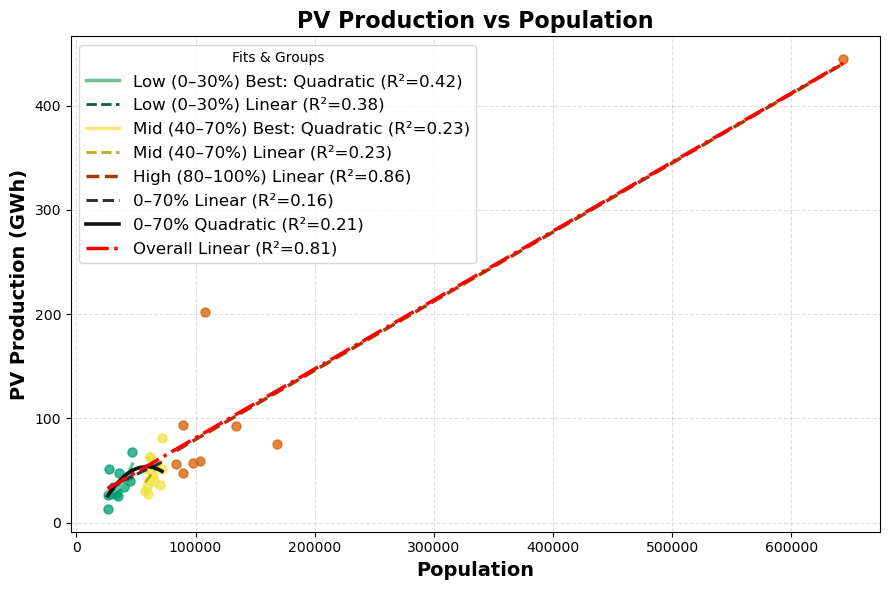

📊 R² Summary:
Low (0–30%)   : Linear R²=0.381, Best=Quadratic (R²=0.424)
Mid (40–70%)  : Linear R²=0.227, Best=Quadratic (R²=0.229)
High (80–100%): Linear R²=0.861

0–70% aggregate fits: Linear R²=0.158, Quadratic R²=0.209

Overall (0–100%) Linear Fit: R²=0.808


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Population'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Population', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Production (GWh)', fontsize=14, fontweight='bold')
ax.set_title('PV Production vs Population', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=12)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


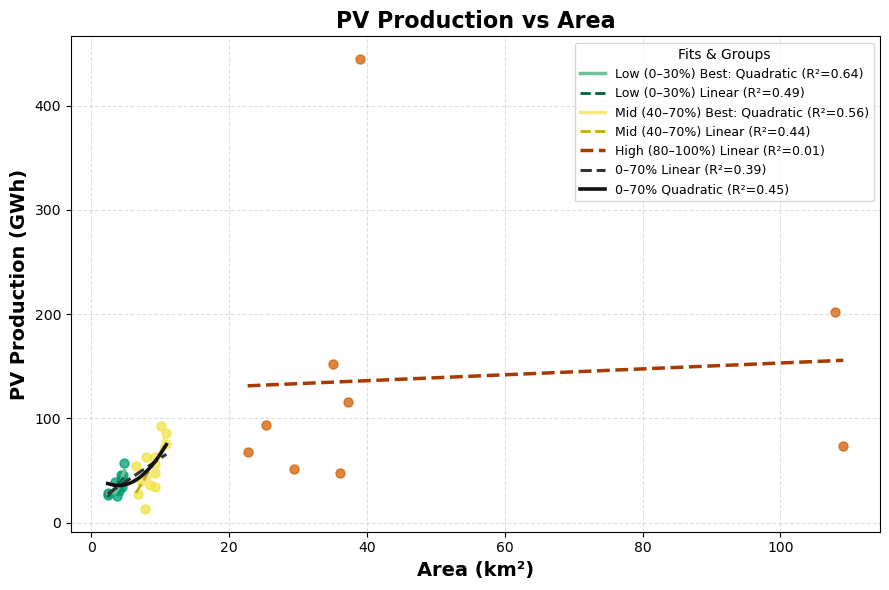

📊 R² Summary:
Low (0–30%)   : Linear R²=0.487, Best=Quadratic (R²=0.642)
Mid (40–70%)  : Linear R²=0.444, Best=Quadratic (R²=0.561)
High (80–100%): Linear R²=0.006

0–70% aggregate fits: Linear R²=0.385, Quadratic R²=0.446

Overall (0–100%) Linear Fit: R²=0.224


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Area'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups (note: 30–40 and 70–80 intentionally excluded)
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")



# --------- Aesthetics ----------
ax.set_xlabel('Area (km²)', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Production (GWh)', fontsize=14, fontweight='bold')
ax.set_title('PV Production vs Area', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


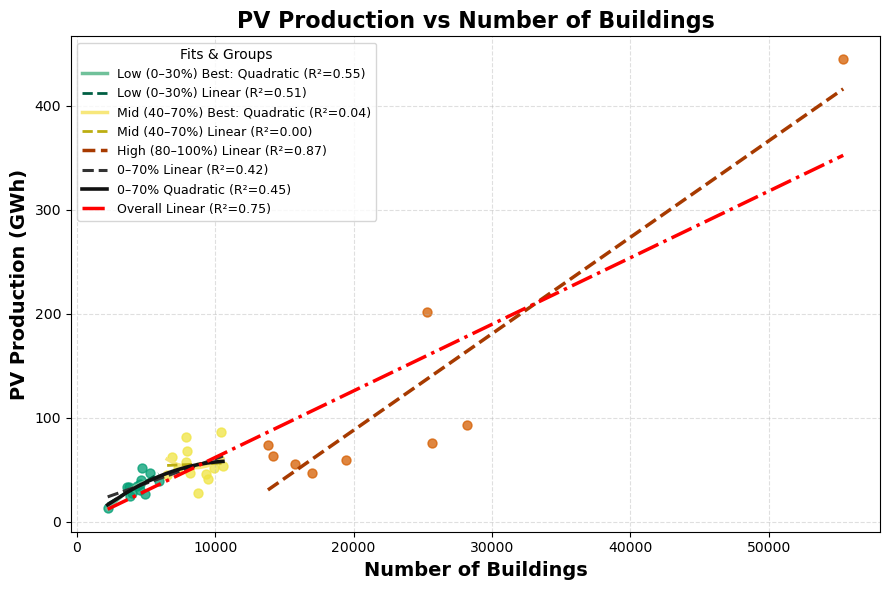

📊 R² Summary:
Low (0–30%)   : Linear R²=0.511, Best=Quadratic (R²=0.554)
Mid (40–70%)  : Linear R²=0.002, Best=Quadratic (R²=0.043)
High (80–100%): Linear R²=0.866

0–70% aggregate fits: Linear R²=0.422, Quadratic R²=0.447

Overall (0–100%) Linear Fit: R²=0.753


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'buildings'
y_col = 'PV Production Gwh – Only BBE'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Number of Buildings', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Production (GWh)', fontsize=14, fontweight='bold')
ax.set_title('PV Production vs Number of Buildings', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


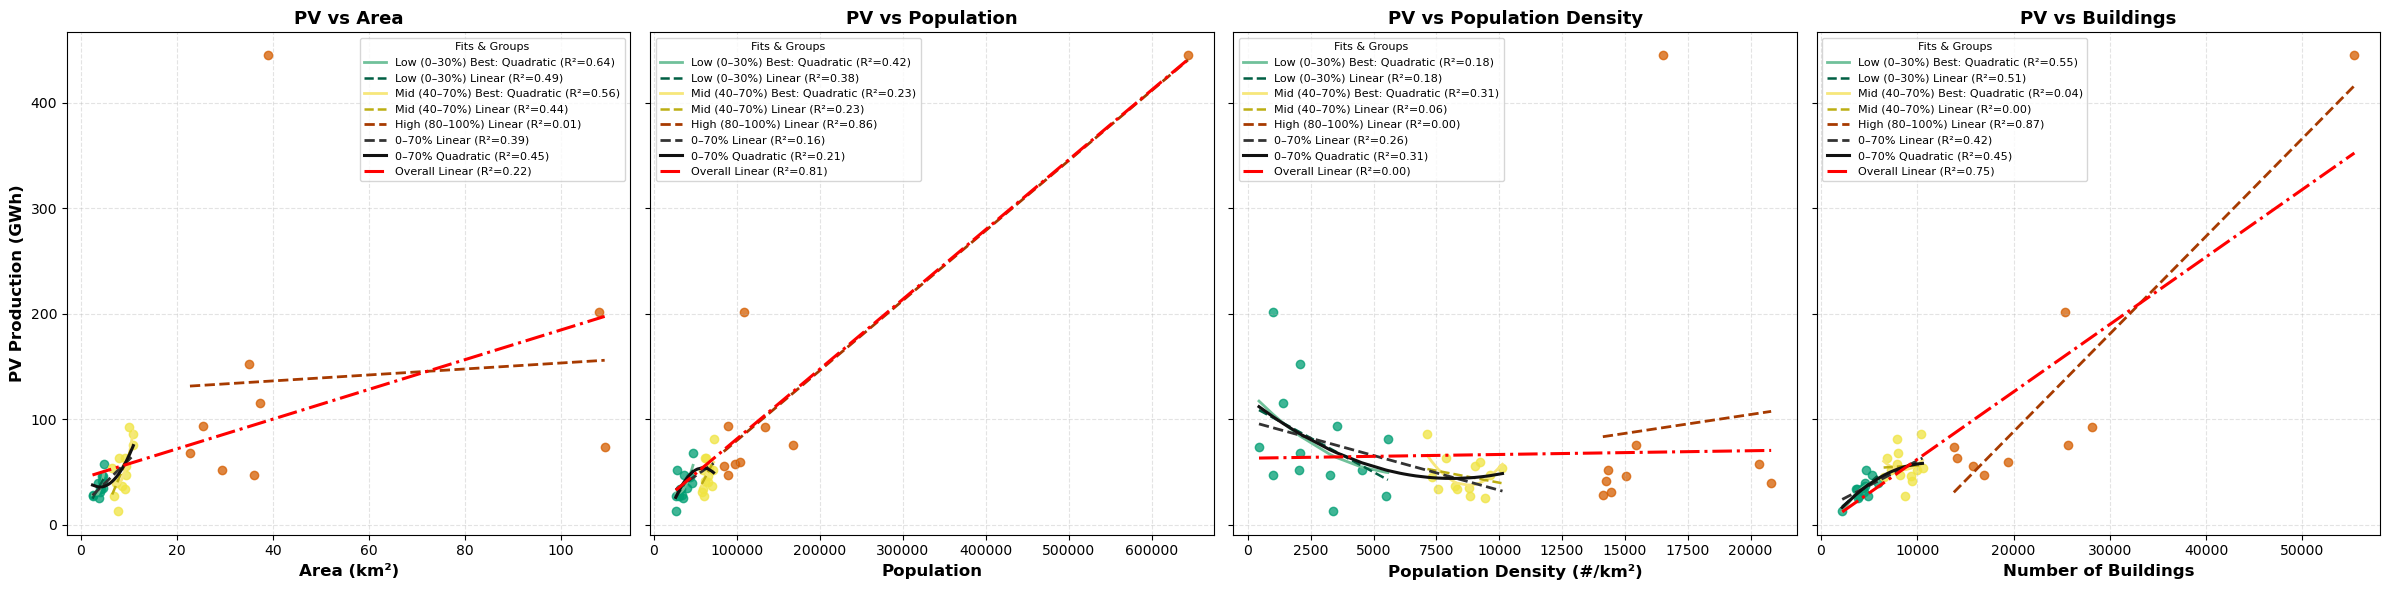

📊 R² summaries per subplot:

— Area —
  Low (0–30%): Linear R²=0.487, Best=Quadratic (R²=0.642)
  Mid (40–70%): Linear R²=0.444, Best=Quadratic (R²=0.561)
  High (80–100%): Linear R²=0.006
  0–70% aggregate: Linear R²=0.385, Quadratic R²=0.446
  Overall Linear (0–100%): R²=0.224

— Population —
  Low (0–30%): Linear R²=0.381, Best=Quadratic (R²=0.424)
  Mid (40–70%): Linear R²=0.227, Best=Quadratic (R²=0.229)
  High (80–100%): Linear R²=0.861
  0–70% aggregate: Linear R²=0.158, Quadratic R²=0.209
  Overall Linear (0–100%): R²=0.808

— Pop Dens —
  Low (0–30%): Linear R²=0.176, Best=Quadratic (R²=0.185)
  Mid (40–70%): Linear R²=0.061, Best=Quadratic (R²=0.307)
  High (80–100%): Linear R²=0.005
  0–70% aggregate: Linear R²=0.260, Quadratic R²=0.306
  Overall Linear (0–100%): R²=0.001

— buildings —
  Low (0–30%): Linear R²=0.511, Best=Quadratic (R²=0.554)
  Mid (40–70%): Linear R²=0.002, Best=Quadratic (R²=0.043)
  High (80–100%): Linear R²=0.866
  0–70% aggregate: Linear R²=0.422, Quad

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== CONFIG ====
Y_COL = 'PV Production Gwh – Only BBE'
X_SPECS = [
    ('Area', 'Area (km²)', 'PV vs Area'),
    ('Population', 'Population', 'PV vs Population'),
    ('Pop Dens', 'Population Density (#/km²)', 'PV vs Population Density'),
    ('buildings', 'Number of Buildings', 'PV vs Buildings'),
]

# Scatter colors (percentile bands)
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',  # green
    'Mid (40–70%)': '#f0e442',  # yellow
    'High (80–100%)': '#d55e00' # red
}

# Line colors
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

def plot_one(ax, df, x_col, y_col, x_label, title, legend_fontsize=8):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    if len(x) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        return {}

    # Percentiles (per x variable)
    p30 = np.percentile(x, 30)
    p40 = np.percentile(x, 40)
    p70 = np.percentile(x, 70)
    p80 = np.percentile(x, 80)

    # Groups (note: 30–40 and 70–80 excluded)
    groups = {
        'Low (0–30%)':     (x <= p30),
        'Mid (40–70%)':    (x > p40) & (x <= p70),
        'High (80–100%)':  (x > p80)
    }

    results = {}

    # --- Plot per-group points and fits ---
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear fit
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)

        if "High" not in label:
            # Test best fit among linear, log, exp, quadratic
            forms = {'Linear': r2_lin}

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                y_pred = np.polyval(p, np.log(xg))
                forms['Logarithmic'] = compute_r2(yg, y_pred)

            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                y_pred = np.exp(np.polyval(p, xg))
                forms['Exponential'] = compute_r2(yg, y_pred)

            p = np.polyfit(xg, yg, 2)
            y_pred = np.polyval(p, xg)
            forms['Quadratic'] = compute_r2(yg, y_pred)

            best_form = max(forms, key=forms.get)
            best_r2 = forms[best_form]
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

            # Compute best-fit curve
            if best_form == 'Linear':
                y_best = y_lin
            elif best_form == 'Logarithmic':
                p = np.polyfit(np.log(xg), yg, 1)
                y_best = np.polyval(p, np.log(xg))
            elif best_form == 'Exponential':
                p = np.polyfit(xg, np.log(yg), 1)
                y_best = np.exp(np.polyval(p, xg))
            else:  # Quadratic
                y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

            # Scatter + lines
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.0,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=1.8,
                    label=f"{label} Linear (R²={r2_lin:.2f})")

        else:
            # High group: linear only
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # --- Extra fits: combined 0–70% (linear & quadratic) ---
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        y_lin_70 = np.polyval(p_lin_70, x_70)
        r2_lin_70 = compute_r2(y_70, y_lin_70)

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        y_quad_70 = np.polyval(p_quad_70, x_70)
        r2_quad_70 = compute_r2(y_70, y_quad_70)

        order_70 = np.argsort(x_70)
        ax.plot(x_70[order_70], y_lin_70[order_70],
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[order_70], y_quad_70[order_70],
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

    # --- Global (0–100%) linear fit (red dash-dot) ---
    p_all = np.polyfit(x, y, 1)
    y_all = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    order_all = np.argsort(x)
    ax.plot(x[order_all], y_all[order_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")

    # --- Aesthetics for this subplot ---
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=legend_fontsize, title_fontsize=legend_fontsize)

    # Return summary
    results['_overall'] = r2_all
    if len(x_70) >= 3:
        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}
    return results

# ==== CREATE 1x4 PANEL ====
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
summaries = {}

for ax, (x_col, x_label, title) in zip(axes, X_SPECS):
    summaries[x_col] = plot_one(ax, merged, x_col, Y_COL, x_label, title)

# Shared Y label
axes[0].set_ylabel('PV Production (GWh)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==== Console summaries ====
print("📊 R² summaries per subplot:")
for xname, res in summaries.items():
    print(f"\n— {xname} —")
    # Per-group (if present)
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    # 0–70% aggregate
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    # Overall
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


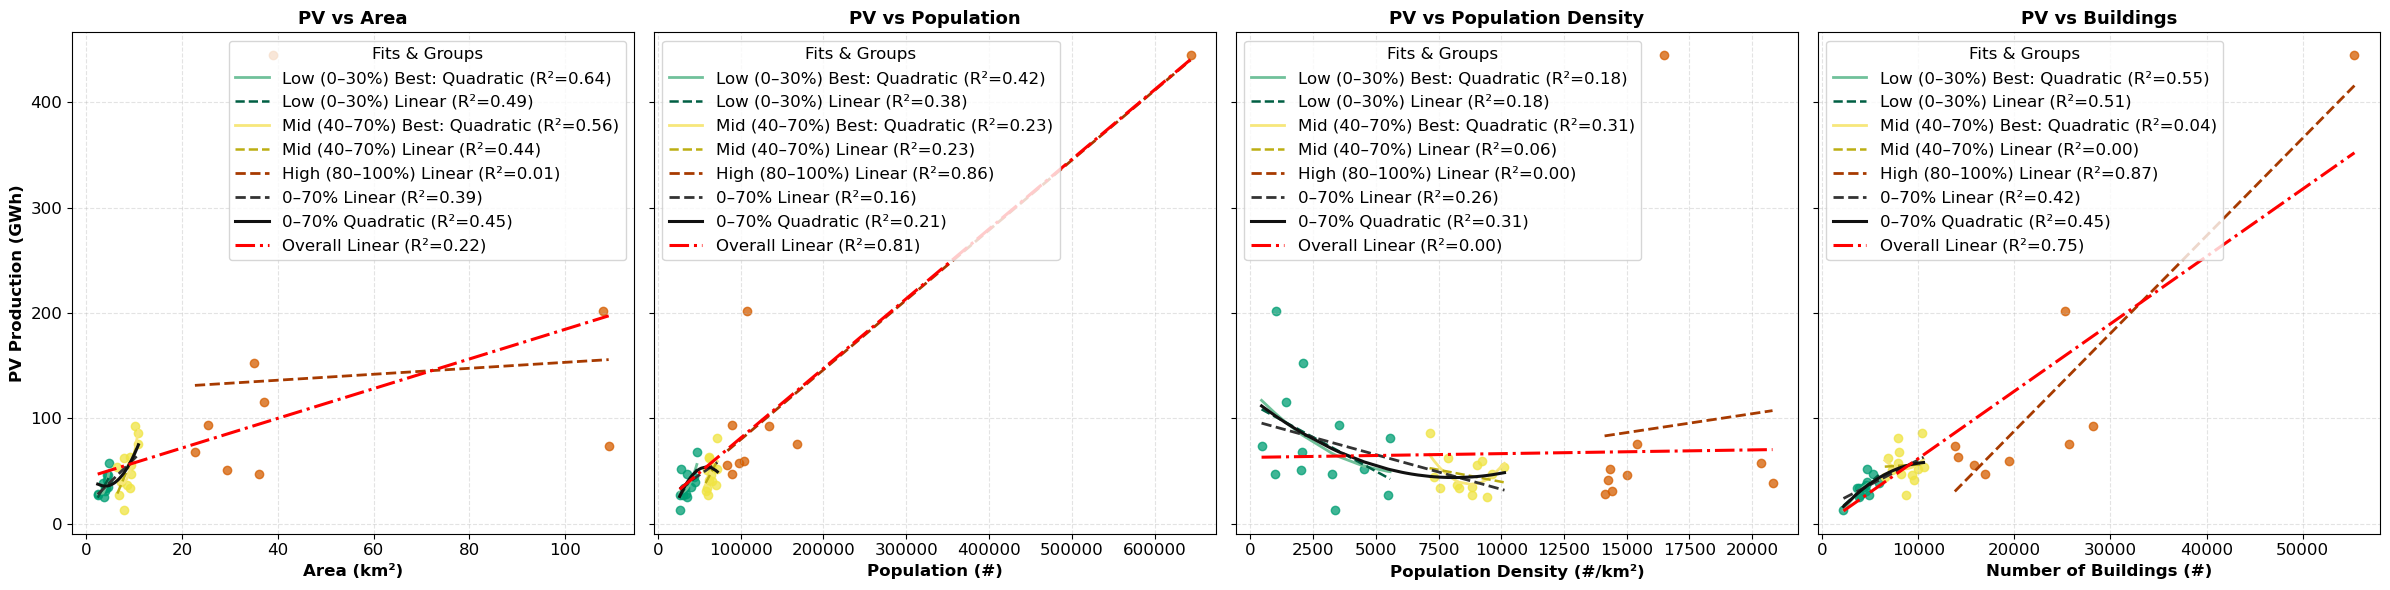

📊 R² summaries per subplot:

— Area —
  Low (0–30%): Linear R²=0.487, Best=Quadratic (R²=0.642)
  Mid (40–70%): Linear R²=0.444, Best=Quadratic (R²=0.561)
  High (80–100%): Linear R²=0.006
  0–70% aggregate: Linear R²=0.385, Quadratic R²=0.446
  Overall Linear (0–100%): R²=0.224

— Population —
  Low (0–30%): Linear R²=0.381, Best=Quadratic (R²=0.424)
  Mid (40–70%): Linear R²=0.227, Best=Quadratic (R²=0.229)
  High (80–100%): Linear R²=0.861
  0–70% aggregate: Linear R²=0.158, Quadratic R²=0.209
  Overall Linear (0–100%): R²=0.808

— Pop Dens —
  Low (0–30%): Linear R²=0.176, Best=Quadratic (R²=0.185)
  Mid (40–70%): Linear R²=0.061, Best=Quadratic (R²=0.307)
  High (80–100%): Linear R²=0.005
  0–70% aggregate: Linear R²=0.260, Quadratic R²=0.306
  Overall Linear (0–100%): R²=0.001

— buildings —
  Low (0–30%): Linear R²=0.511, Best=Quadratic (R²=0.554)
  Mid (40–70%): Linear R²=0.002, Best=Quadratic (R²=0.043)
  High (80–100%): Linear R²=0.866
  0–70% aggregate: Linear R²=0.422, Quad

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== CONFIG ====
Y_COL = 'PV Production Gwh – Only BBE'
X_SPECS = [
    ('Area', 'Area (km²)', 'PV vs Area'),
    ('Population', 'Population (#)', 'PV vs Population'),
    ('Pop Dens', 'Population Density (#/km²)', 'PV vs Population Density'),
    ('buildings', 'Number of Buildings (#)', 'PV vs Buildings'),
]

# Scatter colors (percentile bands)
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',  # green
    'Mid (40–70%)': '#f0e442',  # yellow
    'High (80–100%)': '#d55e00' # red
}

# Line colors
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

def plot_one(ax, df, x_col, y_col, x_label, title, legend_fontsize=12):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    if len(x) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        return {}

    # Percentiles (per x variable)
    p30 = np.percentile(x, 30)
    p40 = np.percentile(x, 40)
    p70 = np.percentile(x, 70)
    p80 = np.percentile(x, 80)

    # Groups (note: 30–40 and 70–80 excluded)
    groups = {
        'Low (0–30%)':     (x <= p30),
        'Mid (40–70%)':    (x > p40) & (x <= p70),
        'High (80–100%)':  (x > p80)
    }

    results = {}

    # --- Plot per-group points and fits ---
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear fit
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)

        if "High" not in label:
            # Test best fit among linear, log, exp, quadratic
            forms = {'Linear': r2_lin}

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                y_pred = np.polyval(p, np.log(xg))
                forms['Logarithmic'] = compute_r2(yg, y_pred)

            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                y_pred = np.exp(np.polyval(p, xg))
                forms['Exponential'] = compute_r2(yg, y_pred)

            p = np.polyfit(xg, yg, 2)
            y_pred = np.polyval(p, xg)
            forms['Quadratic'] = compute_r2(yg, y_pred)

            best_form = max(forms, key=forms.get)
            best_r2 = forms[best_form]
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

            # Compute best-fit curve
            if best_form == 'Linear':
                y_best = y_lin
            elif best_form == 'Logarithmic':
                p = np.polyfit(np.log(xg), yg, 1)
                y_best = np.polyval(p, np.log(xg))
            elif best_form == 'Exponential':
                p = np.polyfit(xg, np.log(yg), 1)
                y_best = np.exp(np.polyval(p, xg))
            else:  # Quadratic
                y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

            # Scatter + lines
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.0,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=1.8,
                    label=f"{label} Linear (R²={r2_lin:.2f})")

        else:
            # High group: linear only
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # --- Extra fits: combined 0–70% (linear & quadratic) ---
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        y_lin_70 = np.polyval(p_lin_70, x_70)
        r2_lin_70 = compute_r2(y_70, y_lin_70)

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        y_quad_70 = np.polyval(p_quad_70, x_70)
        r2_quad_70 = compute_r2(y_70, y_quad_70)

        order_70 = np.argsort(x_70)
        ax.plot(x_70[order_70], y_lin_70[order_70],
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[order_70], y_quad_70[order_70],
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

    # --- Global (0–100%) linear fit (red dash-dot) ---
    p_all = np.polyfit(x, y, 1)
    y_all = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    order_all = np.argsort(x)
    ax.plot(x[order_all], y_all[order_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")

    # --- Aesthetics for this subplot ---
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.tick_params(axis='both', labelsize=12)  # x & y tick labels size 12 (not bold)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=12, title_fontsize=12)

    # Return summary
    results['_overall'] = r2_all
    if len(x_70) >= 3:
        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}
    return results

# ==== CREATE 1x4 PANEL ====
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
summaries = {}

for ax, (x_col, x_label, title) in zip(axes, X_SPECS):
    summaries[x_col] = plot_one(ax, merged, x_col, Y_COL, x_label, title)

# Shared Y label
axes[0].set_ylabel('PV Production (GWh)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==== Console summaries ====
print("📊 R² summaries per subplot:")
for xname, res in summaries.items():
    print(f"\n— {xname} —")
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


In [124]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement',
       'poverty_bin', 'Sav_100', 'Sav_10', 'Sav_100_bin'],
      dtype='object')

In [126]:
merged["Adequacy"].describe()

count    43.000000
mean      0.351737
std       0.180142
min       0.153912
25%       0.237208
50%       0.285694
75%       0.394227
max       0.980399
Name: Adequacy, dtype: float64

In [127]:
merged["PV Adequacy"]=merged["Adequacy"]*100

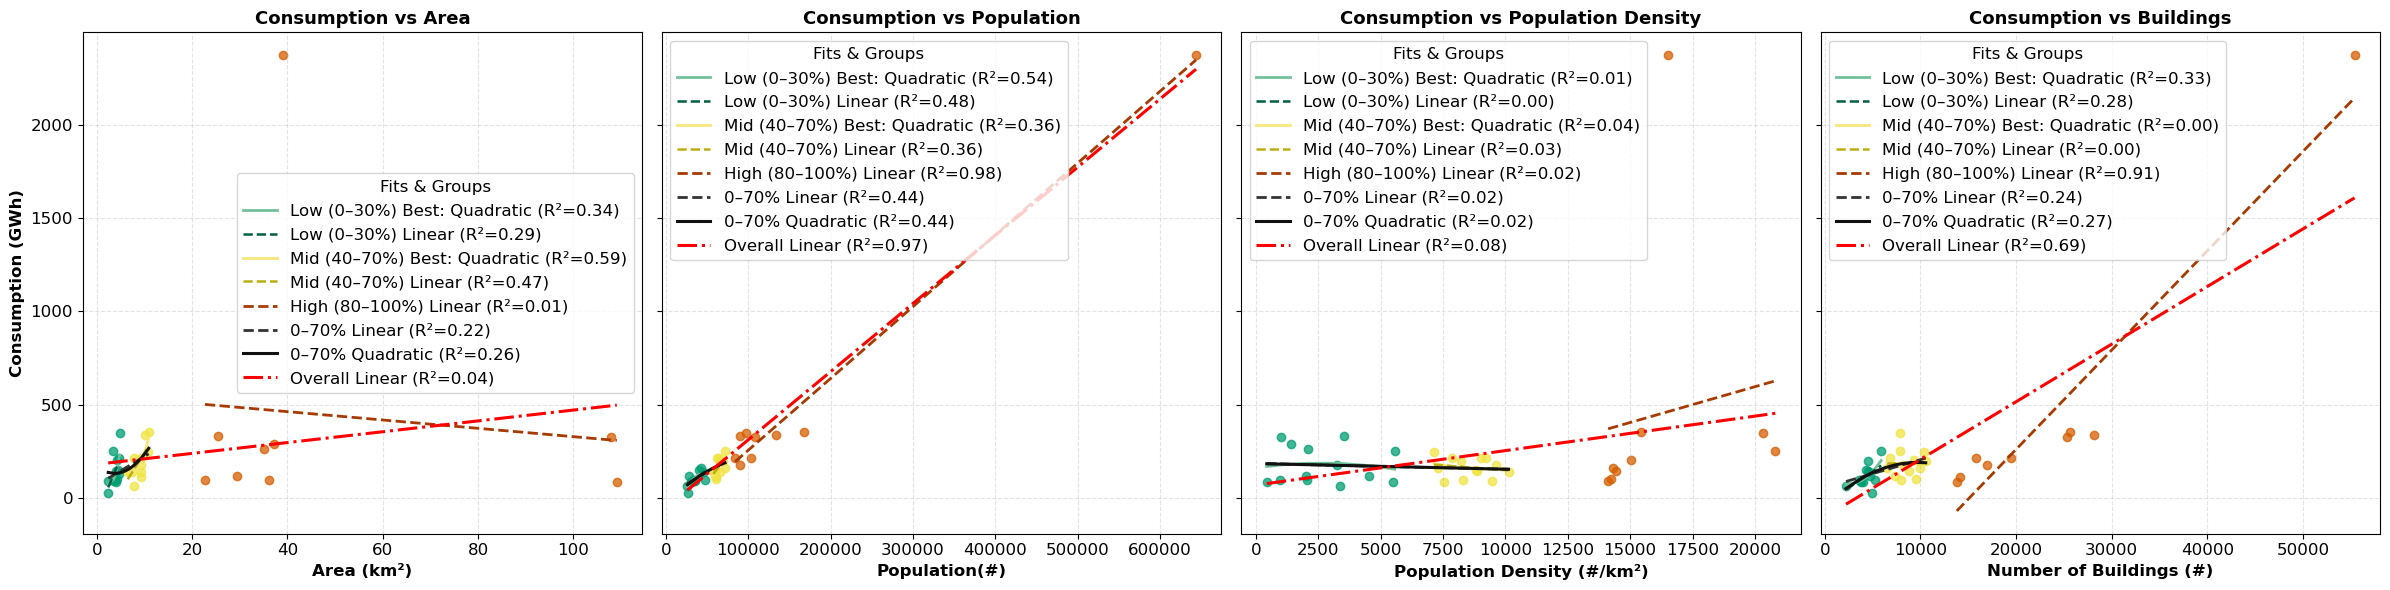

📊 R² summaries per subplot:

— Area —
  Low (0–30%): Linear R²=0.292, Best=Quadratic (R²=0.336)
  Mid (40–70%): Linear R²=0.474, Best=Quadratic (R²=0.593)
  High (80–100%): Linear R²=0.011
  0–70% aggregate: Linear R²=0.224, Quadratic R²=0.256
  Overall Linear (0–100%): R²=0.037

— Population —
  Low (0–30%): Linear R²=0.480, Best=Quadratic (R²=0.537)
  Mid (40–70%): Linear R²=0.359, Best=Quadratic (R²=0.365)
  High (80–100%): Linear R²=0.985
  0–70% aggregate: Linear R²=0.438, Quadratic R²=0.442
  Overall Linear (0–100%): R²=0.969

— Pop Dens —
  Low (0–30%): Linear R²=0.003, Best=Quadratic (R²=0.012)
  Mid (40–70%): Linear R²=0.033, Best=Quadratic (R²=0.040)
  High (80–100%): Linear R²=0.019
  0–70% aggregate: Linear R²=0.015, Quadratic R²=0.015
  Overall Linear (0–100%): R²=0.078

— buildings —
  Low (0–30%): Linear R²=0.285, Best=Quadratic (R²=0.333)
  Mid (40–70%): Linear R²=0.000, Best=Quadratic (R²=0.003)
  High (80–100%): Linear R²=0.914
  0–70% aggregate: Linear R²=0.240, Quad

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== CONFIG ====
Y_COL = 'BBE SC1_100 – Consumption GWh'
Y_LABEL = 'Consumption (GWh)'
X_SPECS = [
    ('Area', 'Area (km²)', 'Consumption vs Area'),
    ('Population', 'Population(#)', 'Consumption vs Population'),
    ('Pop Dens', 'Population Density (#/km²)', 'Consumption vs Population Density'),
    ('buildings', 'Number of Buildings (#)', 'Consumption vs Buildings'),
]

# Scatter colors (percentile bands)
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}

# Line colors
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

def plot_one(ax, df, x_col, y_col, x_label, title, legend_fontsize=12):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    if len(x) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        return {}

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)': (x <= p30),
        'Mid (40–70%)': (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # --- Plot per-group points and fits ---
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear fit
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)

        if "High" not in label:
            # Test best fit among linear, log, exp, quadratic
            forms = {'Linear': r2_lin}

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                forms['Logarithmic'] = compute_r2(yg, np.polyval(p, np.log(xg)))

            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                forms['Exponential'] = compute_r2(yg, np.exp(np.polyval(p, xg)))

            p = np.polyfit(xg, yg, 2)
            forms['Quadratic'] = compute_r2(yg, np.polyval(p, xg))

            best_form = max(forms, key=forms.get)
            best_r2 = forms[best_form]
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

            # Compute best-fit
            if best_form == 'Linear':
                y_best = y_lin
            elif best_form == 'Logarithmic':
                p = np.polyfit(np.log(xg), yg, 1)
                y_best = np.polyval(p, np.log(xg))
            elif best_form == 'Exponential':
                p = np.polyfit(xg, np.log(yg), 1)
                y_best = np.exp(np.polyval(p, xg))
            else:
                y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

            # Scatter + lines
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.0,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=1.8,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
        else:
            # High group: linear only
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # --- 0–70% combined fits ---
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        r2_lin_70 = compute_r2(y_70, np.polyval(p_lin_70, x_70))

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        r2_quad_70 = compute_r2(y_70, np.polyval(p_quad_70, x_70))

        order_70 = np.argsort(x_70)
        ax.plot(x_70[order_70], np.polyval(p_lin_70, x_70[order_70]),
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[order_70], np.polyval(p_quad_70, x_70[order_70]),
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

    # --- Overall (0–100%) linear fit ---
    p_all = np.polyfit(x, y, 1)
    y_all = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    order_all = np.argsort(x)
    ax.plot(x[order_all], y_all[order_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")

    # --- Aesthetics ---
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=12, title_fontsize=12)

    results['_overall'] = r2_all
    if len(x_70) >= 3:
        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}
    return results

# ==== CREATE 1×4 PANEL ====
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
summaries = {}

for ax, (x_col, x_label, title) in zip(axes, X_SPECS):
    summaries[x_col] = plot_one(ax, merged, x_col, Y_COL, x_label, title)

# Shared Y label
axes[0].set_ylabel(Y_LABEL, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==== Console summaries ====
print("📊 R² summaries per subplot:")
for xname, res in summaries.items():
    print(f"\n— {xname} —")
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


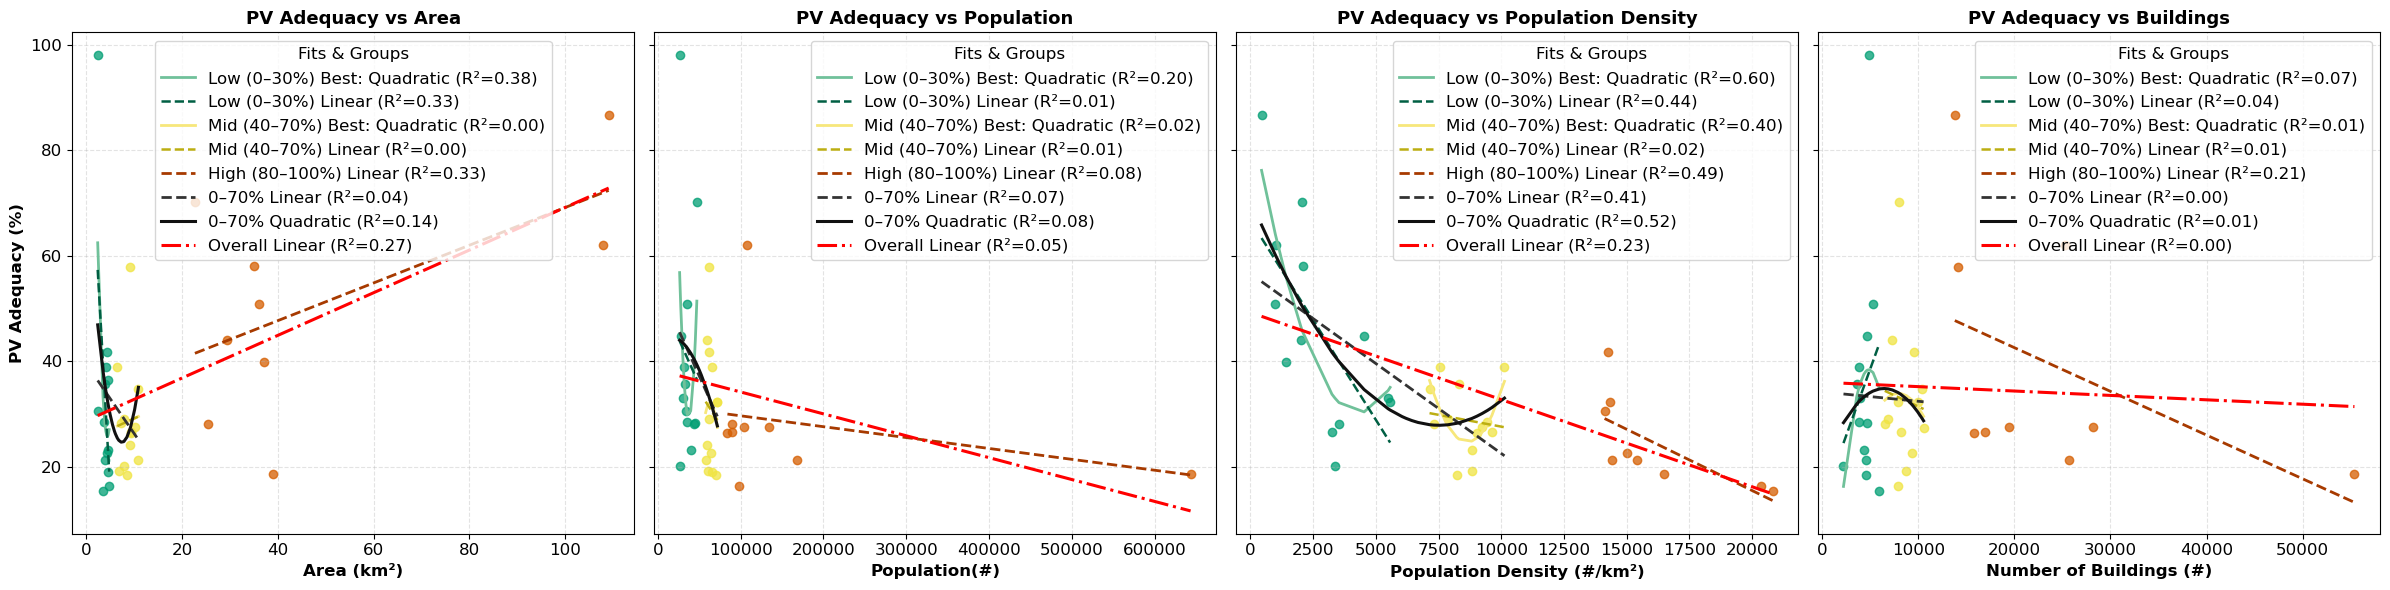

📊 R² summaries per subplot:

— Area —
  Low (0–30%): Linear R²=0.332, Best=Quadratic (R²=0.384)
  Mid (40–70%): Linear R²=0.003, Best=Quadratic (R²=0.003)
  High (80–100%): Linear R²=0.334
  0–70% aggregate: Linear R²=0.045, Quadratic R²=0.139
  Overall Linear (0–100%): R²=0.267

— Population —
  Low (0–30%): Linear R²=0.013, Best=Quadratic (R²=0.199)
  Mid (40–70%): Linear R²=0.010, Best=Quadratic (R²=0.019)
  High (80–100%): Linear R²=0.077
  0–70% aggregate: Linear R²=0.073, Quadratic R²=0.075
  Overall Linear (0–100%): R²=0.046

— Pop Dens —
  Low (0–30%): Linear R²=0.445, Best=Quadratic (R²=0.601)
  Mid (40–70%): Linear R²=0.016, Best=Quadratic (R²=0.398)
  High (80–100%): Linear R²=0.494
  0–70% aggregate: Linear R²=0.408, Quadratic R²=0.523
  Overall Linear (0–100%): R²=0.228

— buildings —
  Low (0–30%): Linear R²=0.044, Best=Quadratic (R²=0.075)
  Mid (40–70%): Linear R²=0.007, Best=Quadratic (R²=0.012)
  High (80–100%): Linear R²=0.206
  0–70% aggregate: Linear R²=0.001, Quad

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== CONFIG ====
Y_COL = 'PV Adequacy'
Y_LABEL = 'PV Adequacy (%)'
X_SPECS = [
    ('Area', 'Area (km²)', 'PV Adequacy vs Area'),
    ('Population', 'Population(#)', 'PV Adequacy vs Population'),
    ('Pop Dens', 'Population Density (#/km²)', 'PV Adequacy vs Population Density'),
    ('buildings', 'Number of Buildings (#)', 'PV Adequacy vs Buildings'),
]

# Scatter colors (percentile bands)
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}

# Line colors
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

def plot_one(ax, df, x_col, y_col, x_label, title, legend_fontsize=12):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    if len(x) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        return {}

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)': (x <= p30),
        'Mid (40–70%)': (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # --- Plot per-group points and fits ---
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear fit
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)

        if "High" not in label:
            # Test best fit among linear, log, exp, quadratic
            forms = {'Linear': r2_lin}

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                forms['Logarithmic'] = compute_r2(yg, np.polyval(p, np.log(xg)))

            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                forms['Exponential'] = compute_r2(yg, np.exp(np.polyval(p, xg)))

            p = np.polyfit(xg, yg, 2)
            forms['Quadratic'] = compute_r2(yg, np.polyval(p, xg))

            best_form = max(forms, key=forms.get)
            best_r2 = forms[best_form]
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

            # Compute best-fit
            if best_form == 'Linear':
                y_best = y_lin
            elif best_form == 'Logarithmic':
                p = np.polyfit(np.log(xg), yg, 1)
                y_best = np.polyval(p, np.log(xg))
            elif best_form == 'Exponential':
                p = np.polyfit(xg, np.log(yg), 1)
                y_best = np.exp(np.polyval(p, xg))
            else:
                y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

            # Scatter + lines
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.0,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=1.8,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
        else:
            # High group: linear only
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # --- 0–70% combined fits ---
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        r2_lin_70 = compute_r2(y_70, np.polyval(p_lin_70, x_70))

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        r2_quad_70 = compute_r2(y_70, np.polyval(p_quad_70, x_70))

        order_70 = np.argsort(x_70)
        ax.plot(x_70[order_70], np.polyval(p_lin_70, x_70[order_70]),
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[order_70], np.polyval(p_quad_70, x_70[order_70]),
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

    # --- Overall (0–100%) linear fit ---
    p_all = np.polyfit(x, y, 1)
    y_all = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    order_all = np.argsort(x)
    ax.plot(x[order_all], y_all[order_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")

    # --- Aesthetics ---
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=12, title_fontsize=12)

    results['_overall'] = r2_all
    if len(x_70) >= 3:
        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}
    return results

# ==== CREATE 1×4 PANEL ====
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
summaries = {}

for ax, (x_col, x_label, title) in zip(axes, X_SPECS):
    summaries[x_col] = plot_one(ax, merged, x_col, Y_COL, x_label, title)

# Shared Y label
axes[0].set_ylabel(Y_LABEL, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==== Console summaries ====
print("📊 R² summaries per subplot:")
for xname, res in summaries.items():
    print(f"\n— {xname} —")
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


In [133]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement',
       'poverty_bin', 'Sav_100', 'Sav_10', 'Sav_100_bin', 'PV Adequacy'],
      dtype='object')

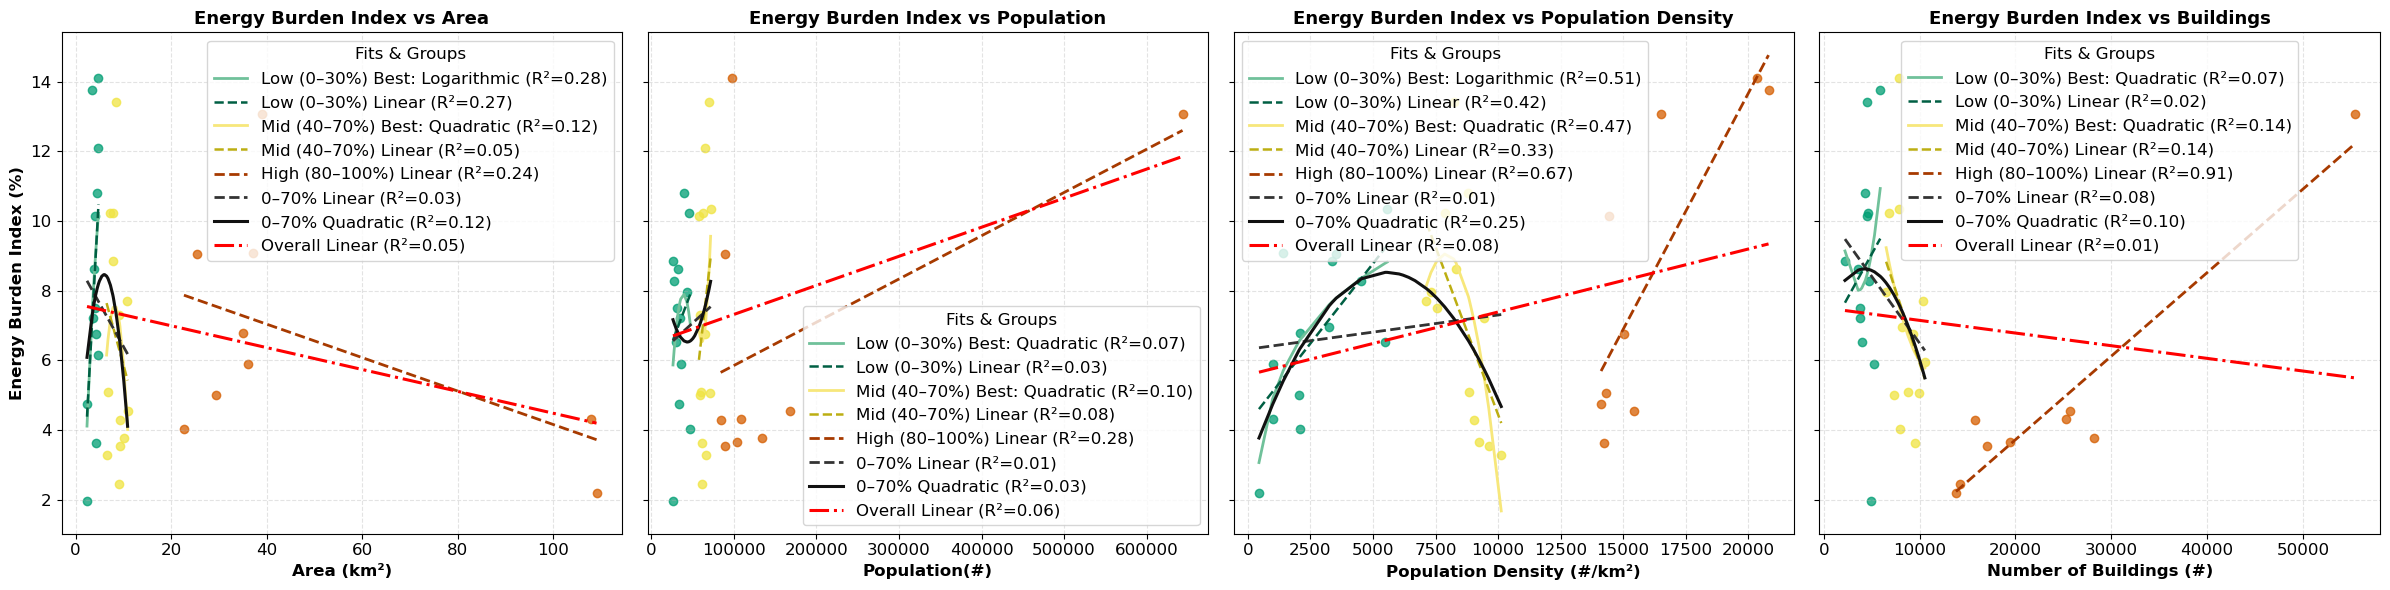

📊 R² summaries per subplot:

— Area —
  Low (0–30%): Linear R²=0.271, Best=Logarithmic (R²=0.283)
  Mid (40–70%): Linear R²=0.045, Best=Quadratic (R²=0.120)
  High (80–100%): Linear R²=0.242
  0–70% aggregate: Linear R²=0.034, Quadratic R²=0.121
  Overall Linear (0–100%): R²=0.049

— Population —
  Low (0–30%): Linear R²=0.031, Best=Quadratic (R²=0.074)
  Mid (40–70%): Linear R²=0.077, Best=Quadratic (R²=0.097)
  High (80–100%): Linear R²=0.275
  0–70% aggregate: Linear R²=0.011, Quadratic R²=0.027
  Overall Linear (0–100%): R²=0.056

— Pop Dens —
  Low (0–30%): Linear R²=0.424, Best=Logarithmic (R²=0.514)
  Mid (40–70%): Linear R²=0.327, Best=Quadratic (R²=0.471)
  High (80–100%): Linear R²=0.670
  0–70% aggregate: Linear R²=0.012, Quadratic R²=0.246
  Overall Linear (0–100%): R²=0.082

— buildings —
  Low (0–30%): Linear R²=0.020, Best=Quadratic (R²=0.068)
  Mid (40–70%): Linear R²=0.137, Best=Quadratic (R²=0.142)
  High (80–100%): Linear R²=0.907
  0–70% aggregate: Linear R²=0.080, 

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== CONFIG ====
Y_COL = 'Energy Poverty Household'
Y_LABEL = 'Energy Burden Index (%)'
X_SPECS = [
    ('Area', 'Area (km²)', 'Energy Burden Index vs Area'),
    ('Population', 'Population(#)', 'Energy Burden Index vs Population'),
    ('Pop Dens', 'Population Density (#/km²)', 'Energy Burden Index vs Population Density'),
    ('buildings', 'Number of Buildings (#)', 'Energy Burden Index vs Buildings'),
]

# Scatter colors (percentile bands)
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}

# Line colors
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

def plot_one(ax, df, x_col, y_col, x_label, title, legend_fontsize=12):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    if len(x) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        return {}

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)': (x <= p30),
        'Mid (40–70%)': (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # --- Plot per-group points and fits ---
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear fit
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)

        if "High" not in label:
            # Test best fit among linear, log, exp, quadratic
            forms = {'Linear': r2_lin}

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                forms['Logarithmic'] = compute_r2(yg, np.polyval(p, np.log(xg)))

            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                forms['Exponential'] = compute_r2(yg, np.exp(np.polyval(p, xg)))

            p = np.polyfit(xg, yg, 2)
            forms['Quadratic'] = compute_r2(yg, np.polyval(p, xg))

            best_form = max(forms, key=forms.get)
            best_r2 = forms[best_form]
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

            # Compute best-fit
            if best_form == 'Linear':
                y_best = y_lin
            elif best_form == 'Logarithmic':
                p = np.polyfit(np.log(xg), yg, 1)
                y_best = np.polyval(p, np.log(xg))
            elif best_form == 'Exponential':
                p = np.polyfit(xg, np.log(yg), 1)
                y_best = np.exp(np.polyval(p, xg))
            else:
                y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

            # Scatter + lines
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.0,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=1.8,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
        else:
            # High group: linear only
            order = np.argsort(xg)
            ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=36)
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # --- 0–70% combined fits ---
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        r2_lin_70 = compute_r2(y_70, np.polyval(p_lin_70, x_70))

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        r2_quad_70 = compute_r2(y_70, np.polyval(p_quad_70, x_70))

        order_70 = np.argsort(x_70)
        ax.plot(x_70[order_70], np.polyval(p_lin_70, x_70[order_70]),
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[order_70], np.polyval(p_quad_70, x_70[order_70]),
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

    # --- Overall (0–100%) linear fit ---
    p_all = np.polyfit(x, y, 1)
    y_all = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    order_all = np.argsort(x)
    ax.plot(x[order_all], y_all[order_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")

    # --- Aesthetics ---
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=12, title_fontsize=12)

    results['_overall'] = r2_all
    if len(x_70) >= 3:
        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}
    return results

# ==== CREATE 1×4 PANEL ====
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
summaries = {}

for ax, (x_col, x_label, title) in zip(axes, X_SPECS):
    summaries[x_col] = plot_one(ax, merged, x_col, Y_COL, x_label, title)

# Shared Y label
axes[0].set_ylabel(Y_LABEL, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==== Console summaries ====
print("📊 R² summaries per subplot:")
for xname, res in summaries.items():
    print(f"\n— {xname} —")
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


In [136]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement',
       'poverty_bin', 'Sav_100', 'Sav_10', 'Sav_100_bin', 'PV Adequacy'],
      dtype='object')

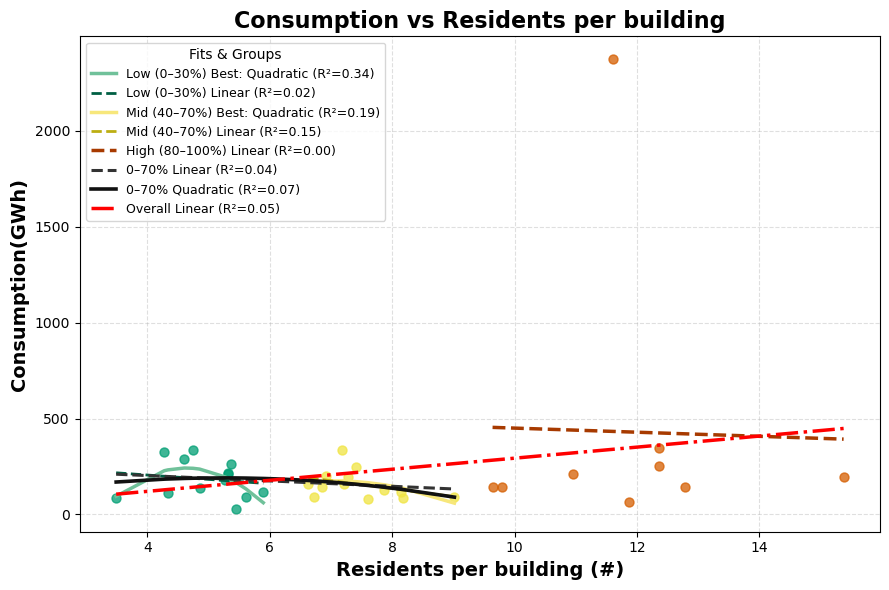

📊 R² Summary:
Low (0–30%)   : Linear R²=0.023, Best=Quadratic (R²=0.338)
Mid (40–70%)  : Linear R²=0.150, Best=Quadratic (R²=0.194)
High (80–100%): Linear R²=0.001

0–70% aggregate fits: Linear R²=0.044, Quadratic R²=0.069

Overall (0–100%) Linear Fit: R²=0.050


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Residents per building'
y_col = 'BBE SC1_100 – Consumption GWh'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Residents per building (#)', fontsize=14, fontweight='bold')
ax.set_ylabel('Consumption(GWh)', fontsize=14, fontweight='bold')
ax.set_title('Consumption vs Residents per building', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


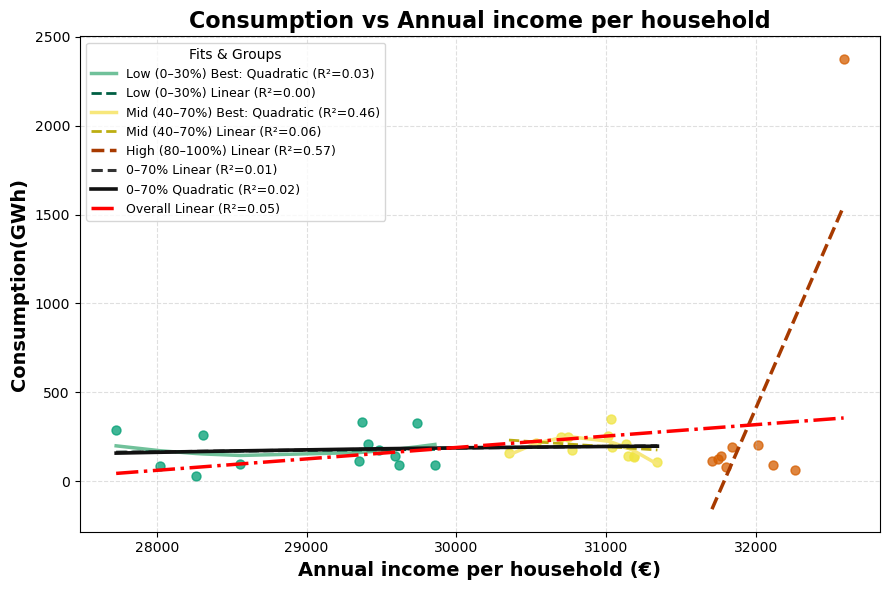

📊 R² Summary:
Low (0–30%)   : Linear R²=0.003, Best=Quadratic (R²=0.034)
Mid (40–70%)  : Linear R²=0.064, Best=Quadratic (R²=0.462)
High (80–100%): Linear R²=0.574

0–70% aggregate fits: Linear R²=0.015, Quadratic R²=0.015

Overall (0–100%) Linear Fit: R²=0.052


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'annual income per household'
y_col = 'BBE SC1_100 – Consumption GWh'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Annual income per building (€)', fontsize=14, fontweight='bold')
ax.set_ylabel('Consumption(GWh)', fontsize=14, fontweight='bold')
ax.set_title('Consumption vs Annual income per building', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


In [143]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement',
       'poverty_bin', 'Sav_100', 'Sav_10', 'Sav_100_bin', 'PV Adequacy'],
      dtype='object')

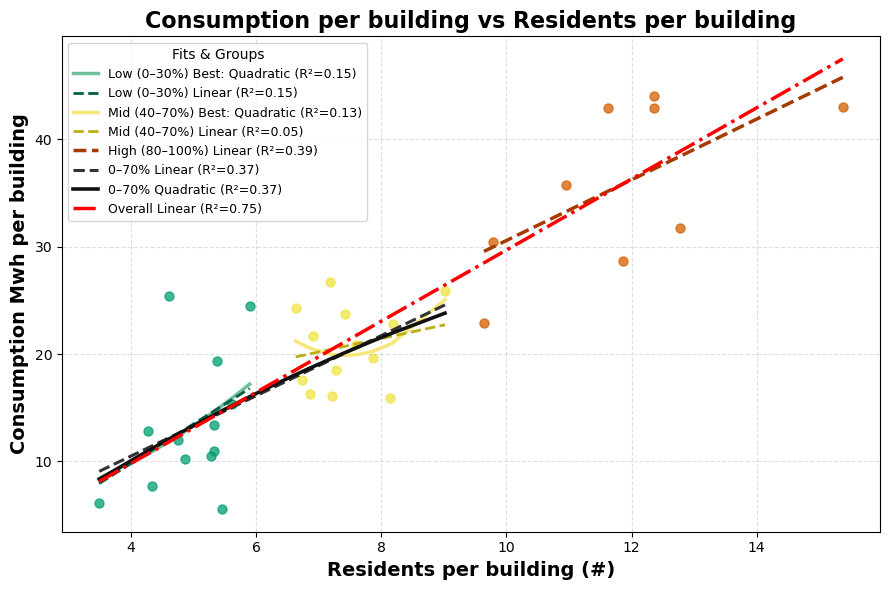

📊 R² Summary:
Low (0–30%)   : Linear R²=0.149, Best=Quadratic (R²=0.151)
Mid (40–70%)  : Linear R²=0.052, Best=Quadratic (R²=0.133)
High (80–100%): Linear R²=0.394

0–70% aggregate fits: Linear R²=0.370, Quadratic R²=0.372

Overall (0–100%) Linear Fit: R²=0.748


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
x_col = 'Residents per building'
y_col = 'Consumption Mwh per building'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Residents per building (#)', fontsize=14, fontweight='bold')
ax.set_ylabel('Consumption per building (Mwh)', fontsize=14, fontweight='bold')
ax.set_title('Consumption per building vs Residents per building', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


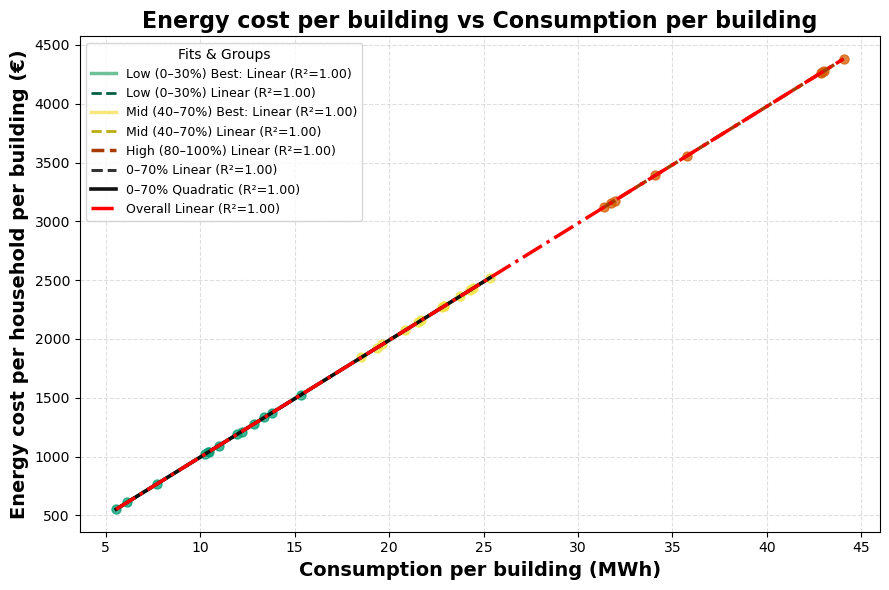

📊 R² Summary:
Low (0–30%)   : Linear R²=1.000, Best=Linear (R²=1.000)
Mid (40–70%)  : Linear R²=1.000, Best=Linear (R²=1.000)
High (80–100%): Linear R²=1.000

0–70% aggregate fits: Linear R²=1.000, Quadratic R²=1.000

Overall (0–100%) Linear Fit: R²=1.000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
y_col = 'Energy cost per household'
x_col = 'Consumption Mwh per building'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Consumption per building (MWh)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy cost per  building (€)', fontsize=14, fontweight='bold')
ax.set_title('Energy cost per building vs Consumption per building', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


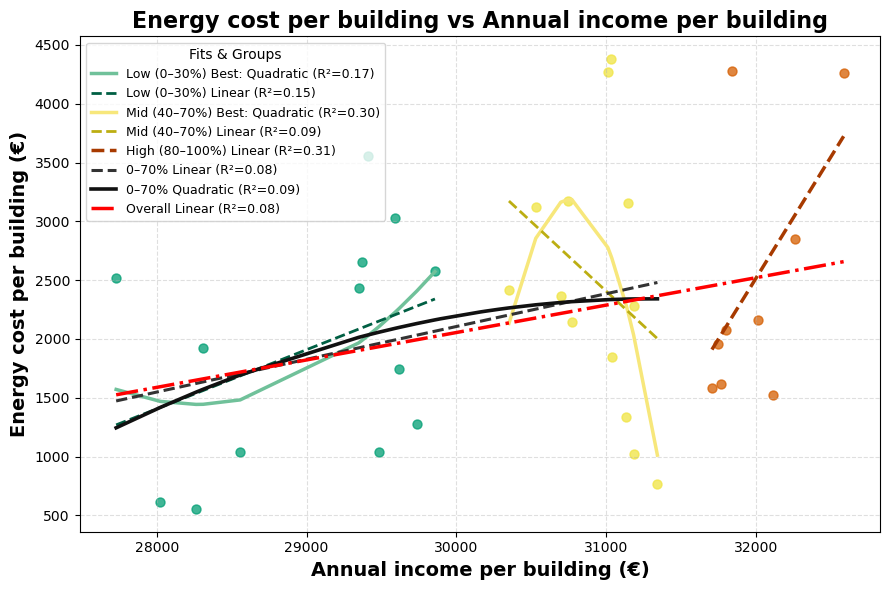

📊 R² Summary:
Low (0–30%)   : Linear R²=0.147, Best=Quadratic (R²=0.171)
Mid (40–70%)  : Linear R²=0.094, Best=Quadratic (R²=0.302)
High (80–100%): Linear R²=0.307

0–70% aggregate fits: Linear R²=0.079, Quadratic R²=0.087

Overall (0–100%) Linear Fit: R²=0.078


In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
y_col = 'Energy cost per household'
x_col = 'annual income per household'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Annual income per building (€)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy cost per building (€)', fontsize=14, fontweight='bold')
ax.set_title('Energy cost per building vs Annual income per building', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


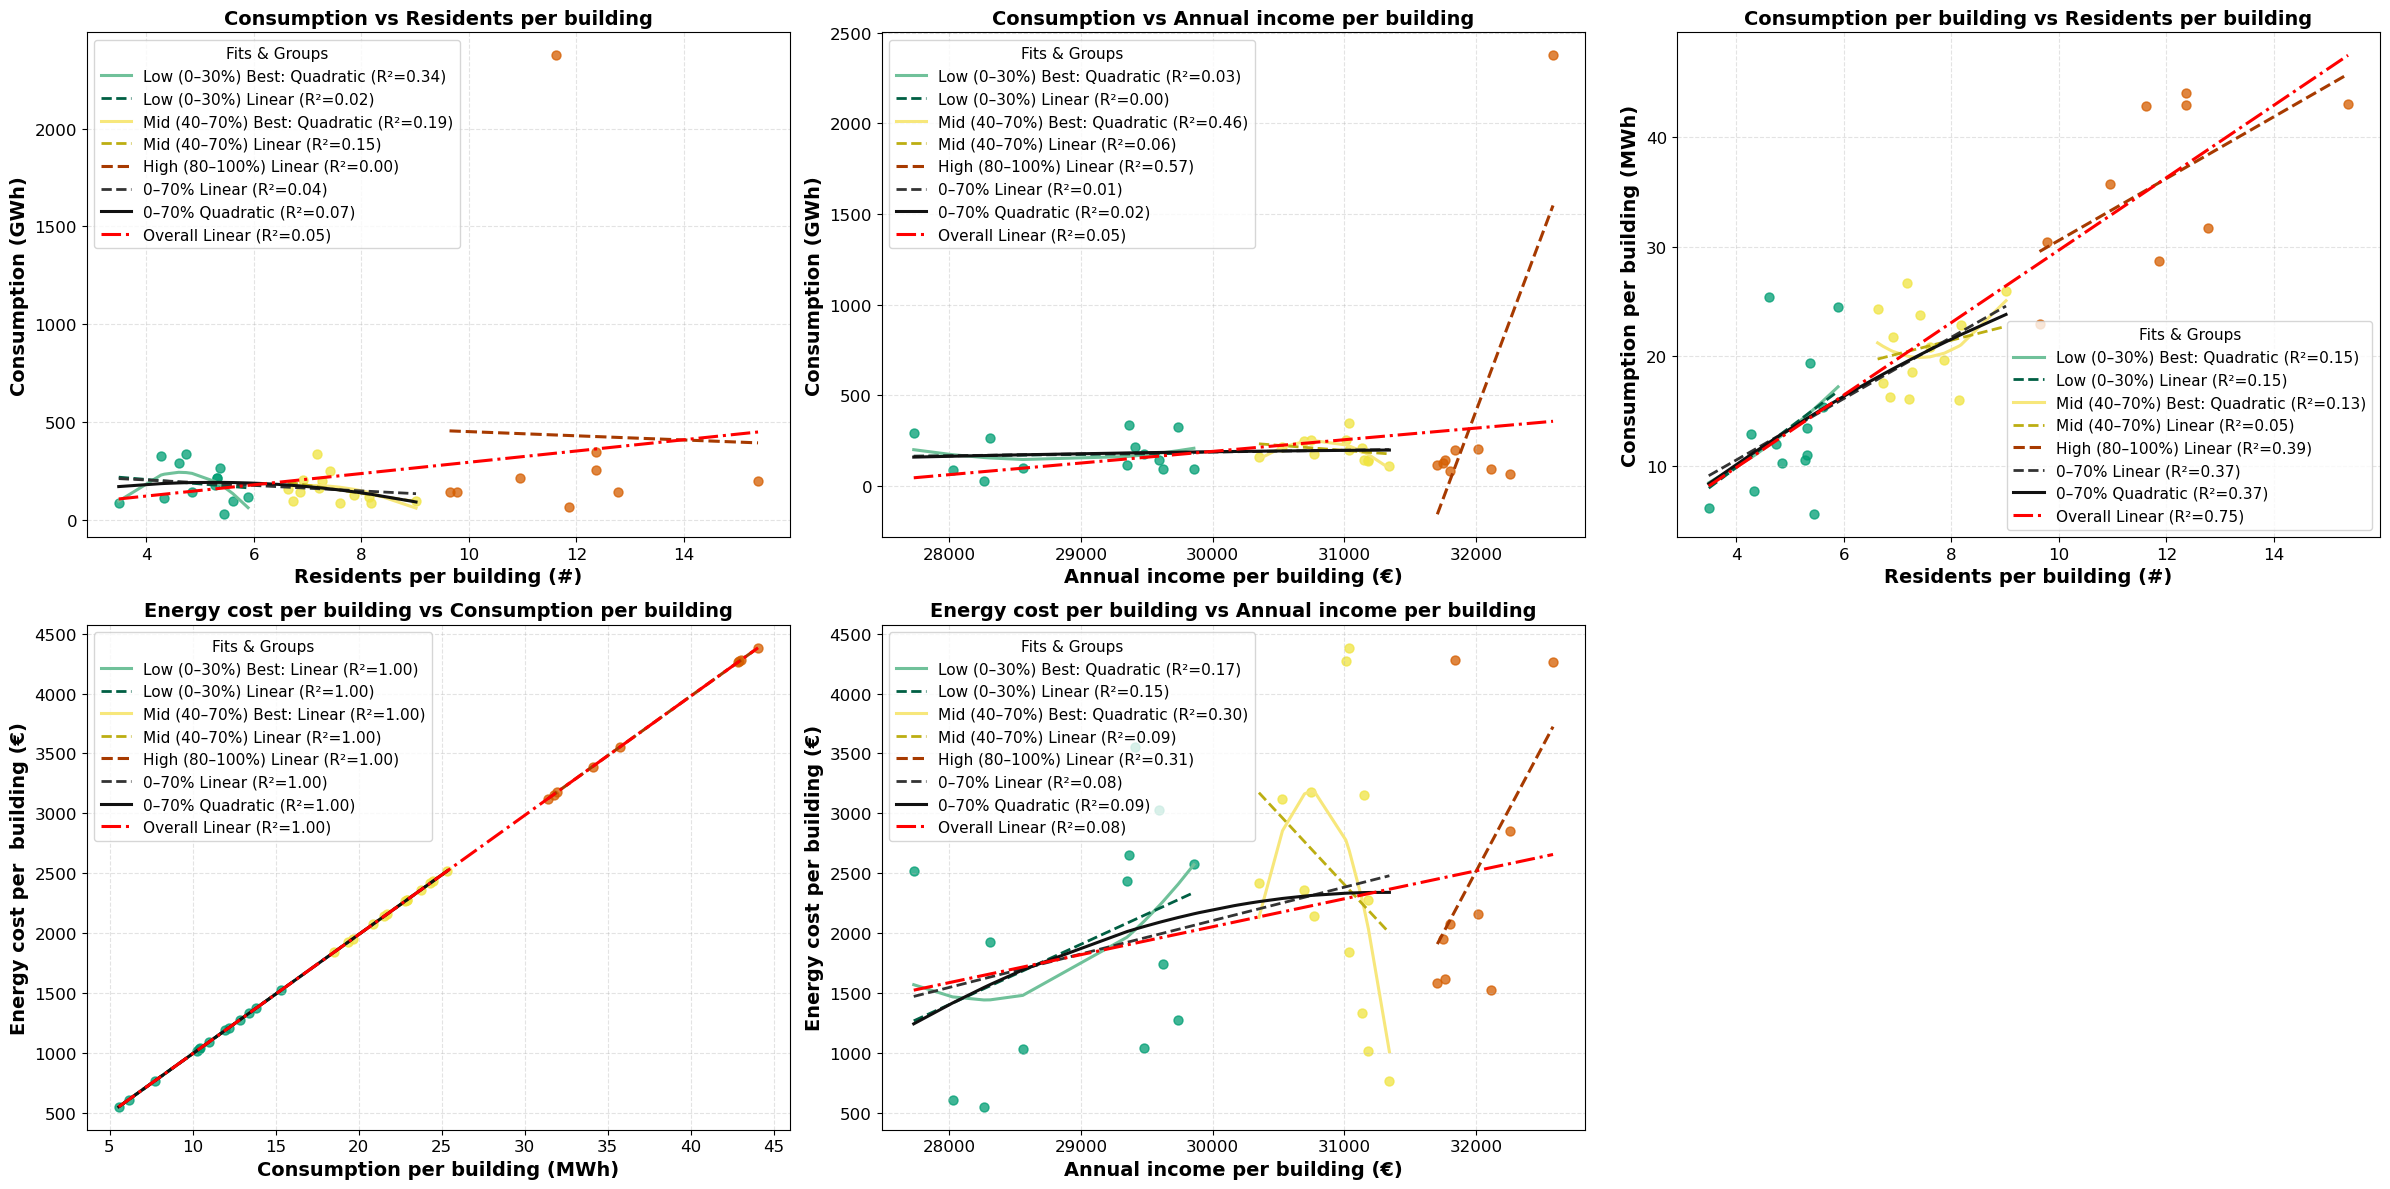


📊 R² summaries per subplot:

— Consumption vs Residents per building —
  Low (0–30%): Linear R²=0.023, Best=Quadratic (R²=0.338)
  Mid (40–70%): Linear R²=0.150, Best=Quadratic (R²=0.194)
  High (80–100%): Linear R²=0.001
  0–70% aggregate: Linear R²=0.044, Quadratic R²=0.069
  Overall Linear (0–100%): R²=0.050

— Consumption vs Annual income per building —
  Low (0–30%): Linear R²=0.003, Best=Quadratic (R²=0.034)
  Mid (40–70%): Linear R²=0.064, Best=Quadratic (R²=0.462)
  High (80–100%): Linear R²=0.574
  0–70% aggregate: Linear R²=0.015, Quadratic R²=0.015
  Overall Linear (0–100%): R²=0.052

— Consumption per building vs Residents per building —
  Low (0–30%): Linear R²=0.149, Best=Quadratic (R²=0.151)
  Mid (40–70%): Linear R²=0.052, Best=Quadratic (R²=0.133)
  High (80–100%): Linear R²=0.394
  0–70% aggregate: Linear R²=0.370, Quadratic R²=0.372
  Overall Linear (0–100%): R²=0.748

— Energy cost per building vs Consumption per building —
  Low (0–30%): Linear R²=1.000, Best=Line

In [ ]:
# 2×3 panel with 5 regression plots (last cell blank)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helper: R² ----------
def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# ---------- Colors ----------
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# ---------- Shared plotter ----------
def plot_regression(ax, df, x_col, y_col, x_label, y_label, title, legend_fontsize=12):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    if data.empty or len(data) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.35)
        return {}

    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)':    (x <= p30),
        'Mid (40–70%)':   (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # Plot per-group
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)
        order = np.argsort(xg)

        ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=42)

        if "High" not in label:
            # Best among Linear/Log/Exp/Quadratic
            forms = {'Linear': r2_lin}
            y_best = y_lin
            best_form = 'Linear'
            best_r2   = r2_lin

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                y_log = np.polyval(p, np.log(xg))
                forms['Logarithmic'] = compute_r2(yg, y_log)
            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                y_exp = np.exp(np.polyval(p, xg))
                forms['Exponential'] = compute_r2(yg, y_exp)
            p = np.polyfit(xg, yg, 2)
            y_quad = np.polyval(p, xg)
            forms['Quadratic'] = compute_r2(yg, y_quad)

            best_form = max(forms, key=forms.get)
            best_r2   = forms[best_form]
            if best_form == 'Logarithmic': y_best = y_log
            elif best_form == 'Exponential': y_best = y_exp
            elif best_form == 'Quadratic':  y_best = y_quad

            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.2,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}
        else:
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.2,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # 0–70% combined fits
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        y_lin_70 = np.polyval(p_lin_70, x_70)
        r2_lin_70 = compute_r2(y_70, y_lin_70)

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        y_quad_70 = np.polyval(p_quad_70, x_70)
        r2_quad_70 = compute_r2(y_70, y_quad_70)

        ord70 = np.argsort(x_70)
        ax.plot(x_70[ord70], y_lin_70[ord70],
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[ord70], y_quad_70[ord70],
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}

    # Overall (0–100%) linear
    p_all  = np.polyfit(x, y, 1)
    y_all  = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    ord_all = np.argsort(x)
    ax.plot(x[ord_all], y_all[ord_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")
    results['_overall'] = r2_all

    # Aesthetics
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=legend_fontsize, title_fontsize=legend_fontsize)

    return results


# ==========================================================
# >>> Build the 2×3 canvas and add your five plots <<<
# Assumes your DataFrame is named `merged` as in your snippets
# ==========================================================
# Plot specifications in the order you described: 0th, 1st, 2nd, 3rd, 4th
SPECS = [
    # 0th plot
    {
        'x_col': 'Residents per building',
        'y_col': 'BBE SC1_100 – Consumption GWh',
        'x_label': 'Residents per building (#)',
        'y_label': 'Consumption (GWh)',
        'title': 'Consumption vs Residents per building'
    },
    # 1st plot
    {
        'x_col': 'annual income per household',
        'y_col': 'BBE SC1_100 – Consumption GWh',
        'x_label': 'Annual income per building (€)',
        'y_label': 'Consumption (GWh)',
        'title': 'Consumption vs Annual income per building'
    },
    # 2nd plot
    {
        'x_col': 'Residents per building',
        'y_col': 'Consumption Mwh per building',
        'x_label': 'Residents per building (#)',
        'y_label': 'Consumption per building (MWh)',
        'title': 'Consumption per building vs Residents per building'
    },
    # 3rd plot
    {
        'x_col': 'Consumption Mwh per building',
        'y_col': 'Energy cost per household',
        'x_label': 'Consumption per building (MWh)',
        'y_label': 'Energy cost per  building (€)',
        'title': 'Energy cost per building vs Consumption per building'
    },
    # 4th plot
    {
        'x_col': 'annual income per household',
        'y_col': 'Energy cost per household',
        'x_label': 'Annual income per building (€)',
        'y_label': 'Energy cost per building (€)',
        'title': 'Energy cost per building vs Annual income per building'
    },
]

fig, axs = plt.subplots(2, 3, figsize=(24, 12))
axs = axs.ravel()

summaries = []

# Plot the 5 specified panels
for i, spec in enumerate(SPECS):
    res = plot_regression(
        axs[i], merged,
        spec['x_col'], spec['y_col'],
        spec['x_label'], spec['y_label'],
        spec['title'],
        legend_fontsize=11
    )
    summaries.append((spec['title'], res))

# Last (6th) cell left blank
axs[5].axis('off')
axs[5].set_title(' ', fontsize=14)

plt.tight_layout()
plt.show()

# --------- Optional: Console summaries ----------
print("\n📊 R² summaries per subplot:")
for title, res in summaries:
    print(f"\n— {title} —")
    if not res:
        print("  Not enough data.")
        continue
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, "
              f"Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


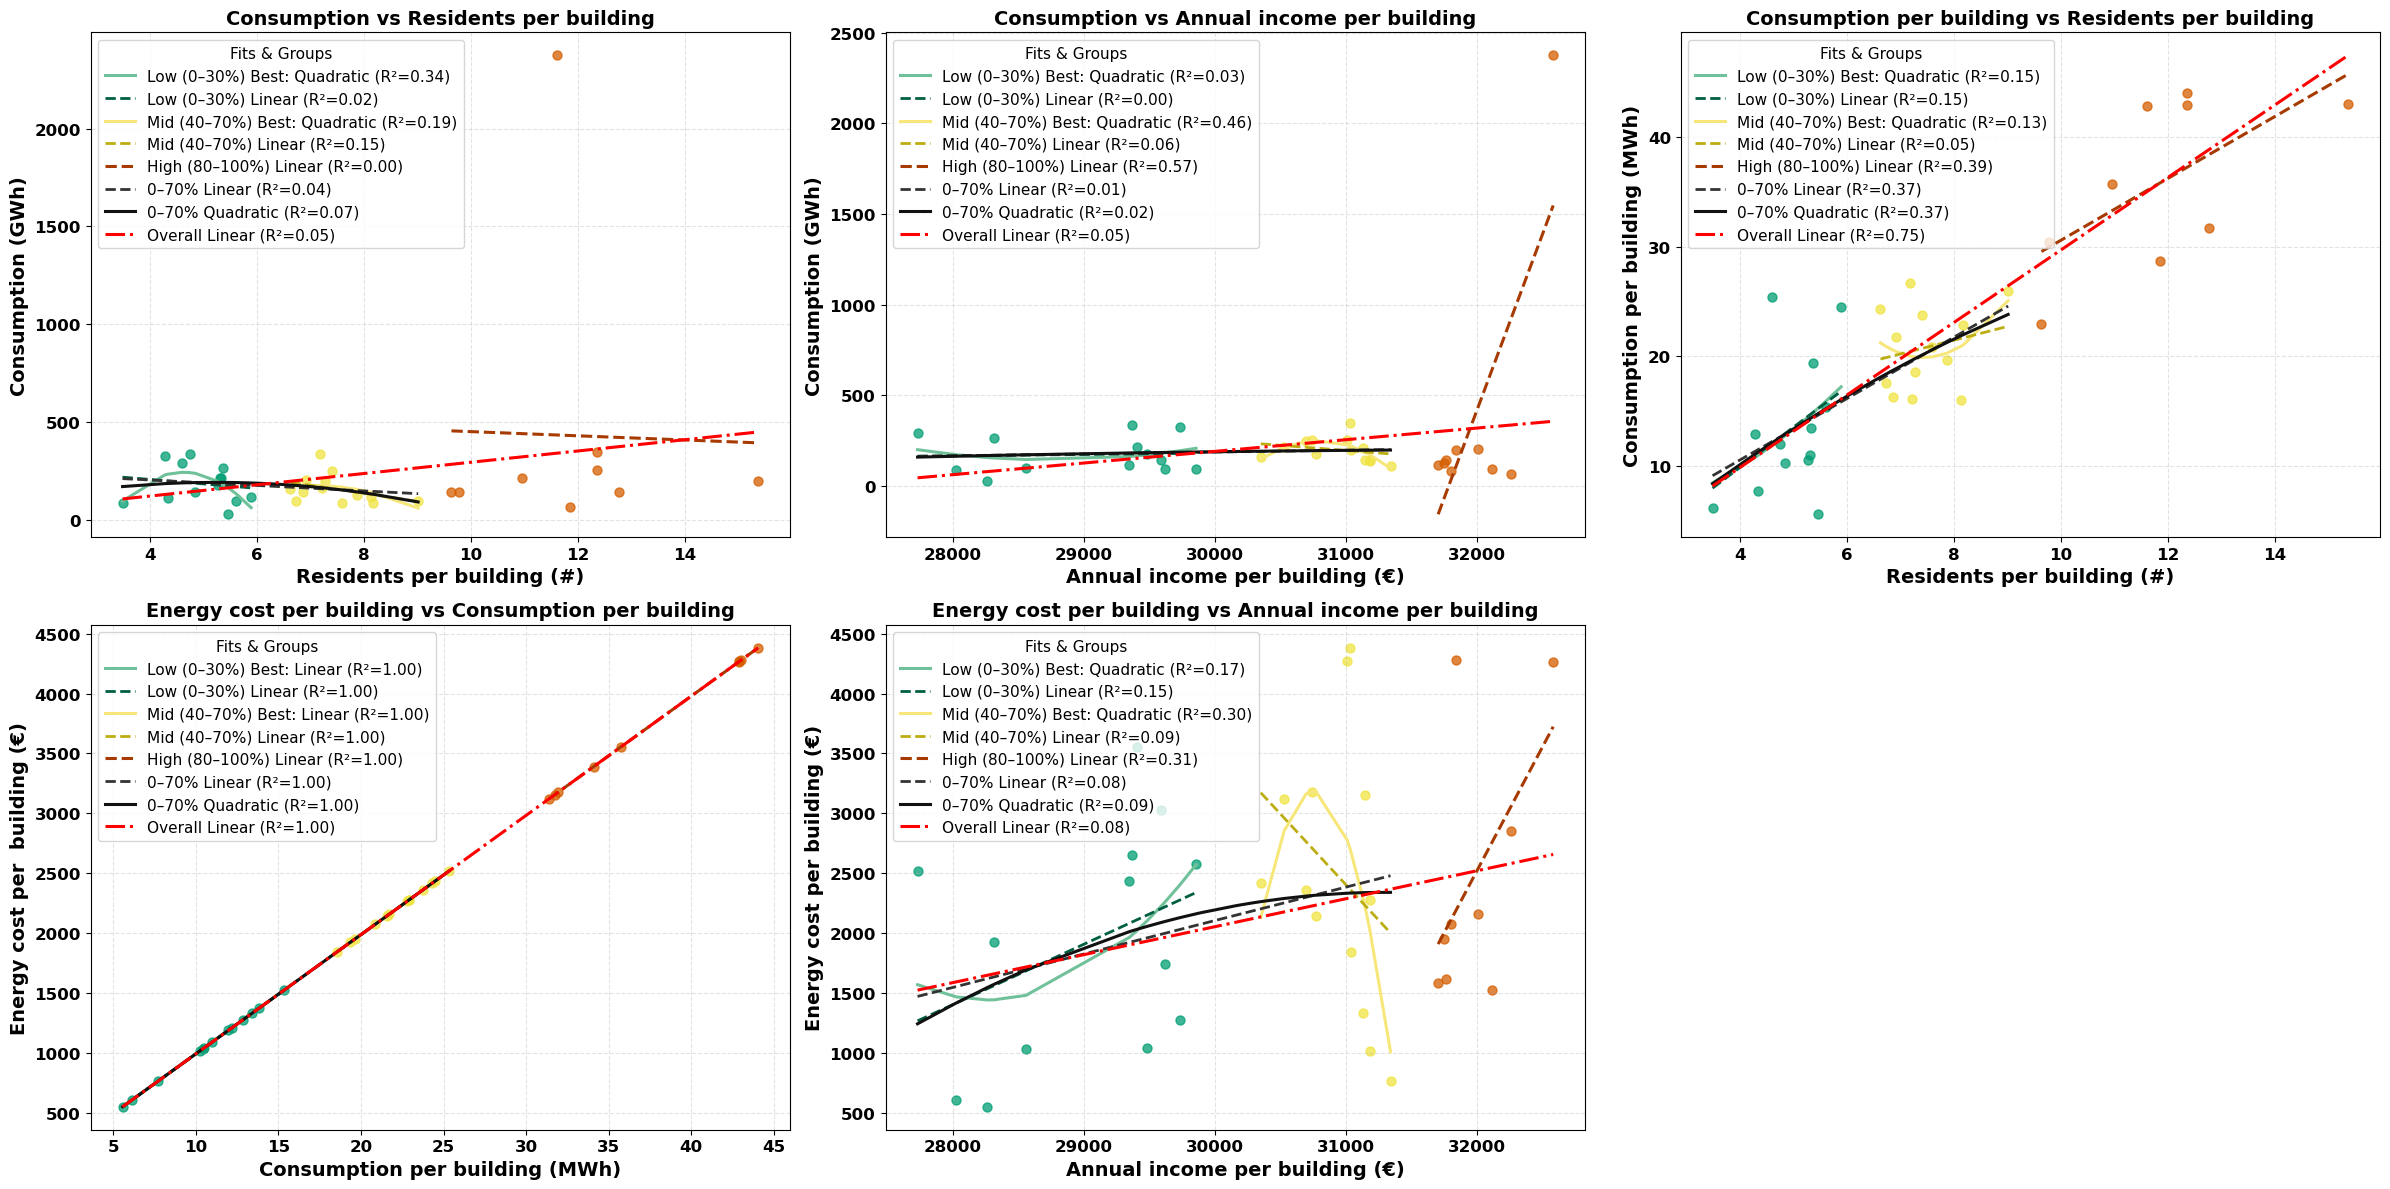


📊 R² summaries per subplot:

— Consumption vs Residents per building —
  Low (0–30%): Linear R²=0.023, Best=Quadratic (R²=0.338)
  Mid (40–70%): Linear R²=0.150, Best=Quadratic (R²=0.194)
  High (80–100%): Linear R²=0.001
  0–70% aggregate: Linear R²=0.044, Quadratic R²=0.069
  Overall Linear (0–100%): R²=0.050

— Consumption vs Annual income per building —
  Low (0–30%): Linear R²=0.003, Best=Quadratic (R²=0.034)
  Mid (40–70%): Linear R²=0.064, Best=Quadratic (R²=0.462)
  High (80–100%): Linear R²=0.574
  0–70% aggregate: Linear R²=0.015, Quadratic R²=0.015
  Overall Linear (0–100%): R²=0.052

— Consumption per building vs Residents per building —
  Low (0–30%): Linear R²=0.149, Best=Quadratic (R²=0.151)
  Mid (40–70%): Linear R²=0.052, Best=Quadratic (R²=0.133)
  High (80–100%): Linear R²=0.394
  0–70% aggregate: Linear R²=0.370, Quadratic R²=0.372
  Overall Linear (0–100%): R²=0.748

— Energy cost per building vs Consumption per building —
  Low (0–30%): Linear R²=1.000, Best=Line

In [149]:
# 2×3 panel with 5 regression plots (last cell blank)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helper: R² ----------
def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# ---------- Colors ----------
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}
LINE_COLORS_BEST = {
    'Low (0–30%)':  '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
LINE_COLORS_LIN = {
    'Low (0–30%)':  '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# ---------- Shared plotter ----------
def _bold_ticks(ax, size=12):
    ax.tick_params(axis='both', labelsize=size)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

def plot_regression(ax, df, x_col, y_col, x_label, y_label, title, legend_fontsize=12):
    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    if data.empty or len(data) < 3:
        ax.set_title(f"{title}\n(Not enough data)")
        ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.35)
        _bold_ticks(ax, size=12)
        return {}

    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)':    (x <= p30),
        'Mid (40–70%)':   (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # Plot per-group
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)
        order = np.argsort(xg)

        ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=42)

        if "High" not in label:
            # Best among Linear/Log/Exp/Quadratic
            forms = {'Linear': r2_lin}
            y_best = y_lin
            best_form = 'Linear'
            best_r2   = r2_lin

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                y_log = np.polyval(p, np.log(xg))
                forms['Logarithmic'] = compute_r2(yg, y_log)
            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                y_exp = np.exp(np.polyval(p, xg))
                forms['Exponential'] = compute_r2(yg, y_exp)
            p = np.polyfit(xg, yg, 2)
            y_quad = np.polyval(p, xg)
            forms['Quadratic'] = compute_r2(yg, y_quad)

            best_form = max(forms, key=forms.get)
            best_r2   = forms[best_form]
            if best_form == 'Logarithmic': y_best = y_log
            elif best_form == 'Exponential': y_best = y_exp
            elif best_form == 'Quadratic':  y_best = y_quad

            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.2,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}
        else:
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.2,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # 0–70% combined fits
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70 = np.polyfit(x_70, y_70, 1)
        y_lin_70 = np.polyval(p_lin_70, x_70)
        r2_lin_70 = compute_r2(y_70, y_lin_70)

        p_quad_70 = np.polyfit(x_70, y_70, 2)
        y_quad_70 = np.polyval(p_quad_70, x_70)
        r2_quad_70 = compute_r2(y_70, y_quad_70)

        ord70 = np.argsort(x_70)
        ax.plot(x_70[ord70], y_lin_70[ord70],
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[ord70], y_quad_70[ord70],
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}

    # Overall (0–100%) linear
    p_all  = np.polyfit(x, y, 1)
    y_all  = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    ord_all = np.argsort(x)
    ax.plot(x[ord_all], y_all[ord_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")
    results['_overall'] = r2_all

    # Aesthetics
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    _bold_ticks(ax, size=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=legend_fontsize, title_fontsize=legend_fontsize)

    return results


# ==========================================================
# >>> Build the 2×3 canvas and add your five plots <<<
# ==========================================================
# Plot specifications in the order you described: 0th, 1st, 2nd, 3rd, 4th
SPECS = [
    # 0th plot
    {
        'x_col': 'Residents per building',
        'y_col': 'BBE SC1_100 – Consumption GWh',
        'x_label': 'Residents per building (#)',
        'y_label': 'Consumption (GWh)',
        'title': 'Consumption vs Residents per building'
    },
    # 1st plot
    {
        'x_col': 'annual income per household',
        'y_col': 'BBE SC1_100 – Consumption GWh',
        'x_label': 'Annual income per building (€)',
        'y_label': 'Consumption (GWh)',
        'title': 'Consumption vs Annual income per building'
    },
    # 2nd plot
    {
        'x_col': 'Residents per building',
        'y_col': 'Consumption Mwh per building',
        'x_label': 'Residents per building (#)',
        'y_label': 'Consumption per building (MWh)',
        'title': 'Consumption per building vs Residents per building'
    },
    # 3rd plot
    {
        'x_col': 'Consumption Mwh per building',
        'y_col': 'Energy cost per household',
        'x_label': 'Consumption per building (MWh)',
        'y_label': 'Energy cost per  building (€)',
        'title': 'Energy cost per building vs Consumption per building'
    },
    # 4th plot
    {
        'x_col': 'annual income per household',
        'y_col': 'Energy cost per household',
        'x_label': 'Annual income per building (€)',
        'y_label': 'Energy cost per building (€)',
        'title': 'Energy cost per building vs Annual income per building'
    },
]

fig, axs = plt.subplots(2, 3, figsize=(24, 12))
axs = axs.ravel()

summaries = []

# Plot the 5 specified panels
for i, spec in enumerate(SPECS):
    res = plot_regression(
        axs[i], merged,
        spec['x_col'], spec['y_col'],
        spec['x_label'], spec['y_label'],
        spec['title'],
        legend_fontsize=11
    )
    summaries.append((spec['title'], res))

# Last (6th) cell left blank
axs[5].axis('off')
axs[5].set_title(' ', fontsize=14)

plt.tight_layout()
plt.show()

# --------- Optional: Console summaries ----------
print("\n📊 R² summaries per subplot:")
for title, res in summaries:
    print(f"\n— {title} —")
    if not res:
        print("  Not enough data.")
        continue
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, "
              f"Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


In [151]:
merged["PV Adequacy"]=merged["Adequacy"]*100

In [152]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement',
       'poverty_bin', 'Sav_100', 'Sav_10', 'Sav_100_bin', 'PV Adequacy'],
      dtype='object')

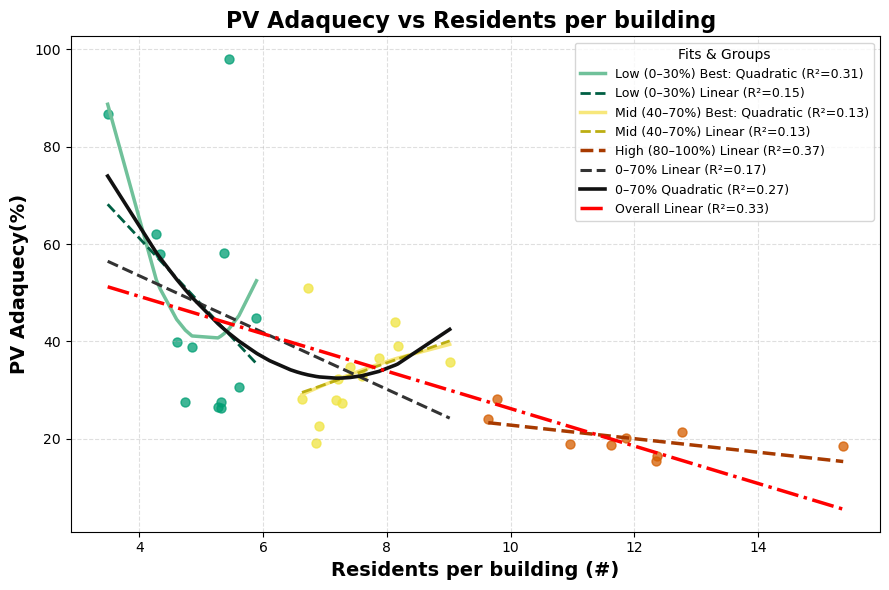

📊 R² Summary:
Low (0–30%)   : Linear R²=0.147, Best=Quadratic (R²=0.305)
Mid (40–70%)  : Linear R²=0.126, Best=Quadratic (R²=0.128)
High (80–100%): Linear R²=0.366

0–70% aggregate fits: Linear R²=0.169, Quadratic R²=0.272

Overall (0–100%) Linear Fit: R²=0.330


In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
y_col = 'PV Adequacy'
x_col = 'Residents per building'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Residents per building (#)', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Adaquecy(%)', fontsize=14, fontweight='bold')
ax.set_title('PV Adaquecy vs Residents per building ', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


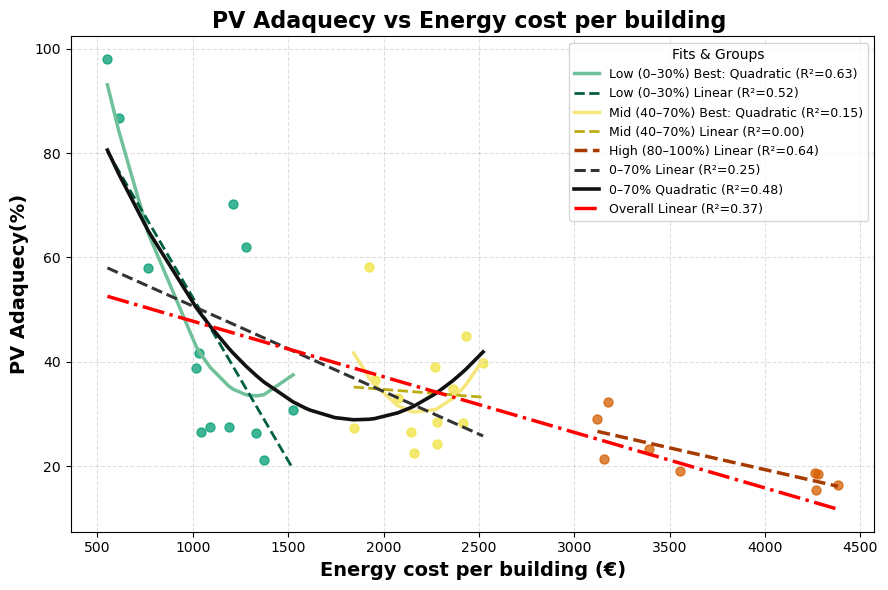

📊 R² Summary:
Low (0–30%)   : Linear R²=0.518, Best=Quadratic (R²=0.634)
Mid (40–70%)  : Linear R²=0.004, Best=Quadratic (R²=0.151)
High (80–100%): Linear R²=0.644

0–70% aggregate fits: Linear R²=0.247, Quadratic R²=0.479

Overall (0–100%) Linear Fit: R²=0.368


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
y_col = 'PV Adequacy'
x_col = 'Energy cost per household'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Energy cost per building (€)', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Adaquecy(%)', fontsize=14, fontweight='bold')
ax.set_title('PV Adaquecy vs Energy cost per building ', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


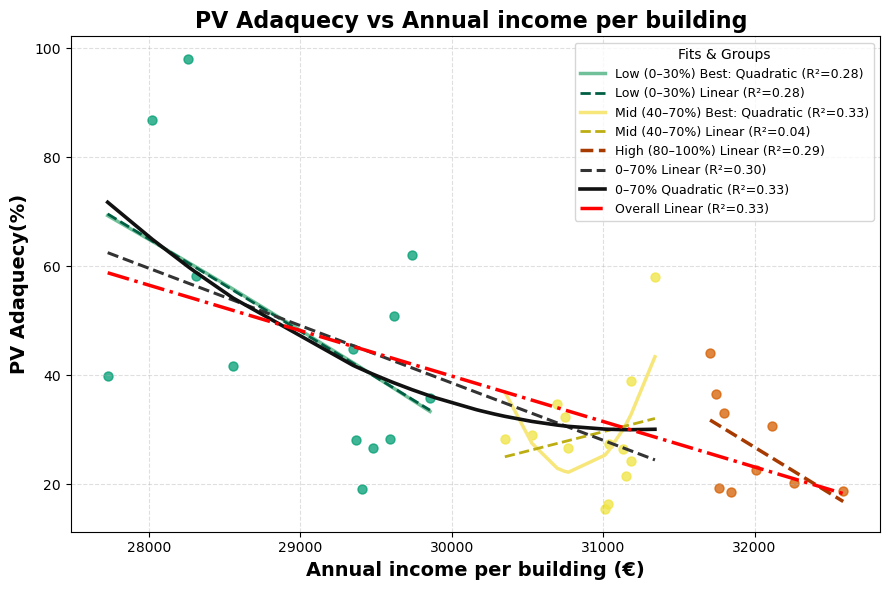

📊 R² Summary:
Low (0–30%)   : Linear R²=0.277, Best=Quadratic (R²=0.277)
Mid (40–70%)  : Linear R²=0.036, Best=Quadratic (R²=0.325)
High (80–100%): Linear R²=0.285

0–70% aggregate fits: Linear R²=0.297, Quadratic R²=0.331

Overall (0–100%) Linear Fit: R²=0.325


In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
y_col = 'PV Adequacy'
x_col = 'annual income per household'

# Prepare data
data = merged[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
x = data[x_col].to_numpy()
y = data[y_col].to_numpy()

# Percentile cutoffs
p30 = np.percentile(x, 30)
p40 = np.percentile(x, 40)
p70 = np.percentile(x, 70)
p80 = np.percentile(x, 80)

# Scatter colors
scatter_colors = {
    'Low (0–30%)': '#009e73',    # Green
    'Mid (40–70%)': '#f0e442',   # Yellow
    'High (80–100%)': '#d55e00'  # Red
}

# Line colors
line_colors_best = {
    'Low (0–30%)': '#70c19a',
    'Mid (40–70%)': '#f7e77b'
}
line_colors_lin = {
    'Low (0–30%)': '#005f43',
    'Mid (40–70%)': '#bcae12',
    'High (80–100%)': '#a73a00'
}

# Groups
groups = {
    'Low (0–30%)': (x <= p30),
    'Mid (40–70%)': (x > p40) & (x <= p70),
    'High (80–100%)': (x > p80)
}

def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

fig, ax = plt.subplots(figsize=(9, 6))
results = {}

# --------- Plot the three percentile groups ----------
for label, mask in groups.items():
    xg, yg = x[mask], y[mask]
    if len(xg) < 3:
        continue

    # --- Linear fit ---
    p_lin = np.polyfit(xg, yg, 1)
    y_lin = np.polyval(p_lin, xg)
    r2_lin = compute_r2(yg, y_lin)

    # --- For Low and Mid groups: find best-fit ---
    if "High" not in label:
        forms = {'Linear': r2_lin}

        # Logarithmic (x>0)
        if np.all(xg > 0):
            p = np.polyfit(np.log(xg), yg, 1)
            y_pred = np.polyval(p, np.log(xg))
            forms['Logarithmic'] = compute_r2(yg, y_pred)

        # Exponential (y>0)
        if np.all(yg > 0):
            p = np.polyfit(xg, np.log(yg), 1)
            y_pred = np.exp(np.polyval(p, xg))
            forms['Exponential'] = compute_r2(yg, y_pred)

        # Quadratic
        p = np.polyfit(xg, yg, 2)
        y_pred = np.polyval(p, xg)
        forms['Quadratic'] = compute_r2(yg, y_pred)

        best_form = max(forms, key=forms.get)
        best_r2 = forms[best_form]
        results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}

        # Compute y_best
        if best_form == 'Linear':
            y_best = y_lin
        elif best_form == 'Logarithmic':
            p = np.polyfit(np.log(xg), yg, 1)
            y_best = np.polyval(p, np.log(xg))
        elif best_form == 'Exponential':
            p = np.polyfit(xg, np.log(yg), 1)
            y_best = np.exp(np.polyval(p, xg))
        else:
            y_best = np.polyval(np.polyfit(xg, yg, 2), xg)

        # Plot scatter + lines
        order = np.argsort(xg)
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        ax.plot(xg[order], y_best[order],
                color=line_colors_best[label], linewidth=2.5,
                label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2,
                label=f"{label} Linear (R²={r2_lin:.2f})")

    # --- For High group: linear only ---
    else:
        ax.scatter(xg, yg, color=scatter_colors[label], alpha=0.75, s=42)
        order = np.argsort(xg)
        ax.plot(xg[order], y_lin[order],
                color=line_colors_lin[label], linestyle='--', linewidth=2.5,
                label=f"{label} Linear (R²={r2_lin:.2f})")
        results[label] = {'Linear': r2_lin}

# --------- EXTRA: Fits for 0–70% combined range (Linear & Quadratic) ----------
mask_0_70 = (x <= p70)
x_70 = x[mask_0_70]
y_70 = y[mask_0_70]

if len(x_70) >= 3:
    # Linear
    p_lin_70 = np.polyfit(x_70, y_70, 1)
    y_lin_70 = np.polyval(p_lin_70, x_70)
    r2_lin_70 = compute_r2(y_70, y_lin_70)

    # Quadratic
    p_quad_70 = np.polyfit(x_70, y_70, 2)
    y_quad_70 = np.polyval(p_quad_70, x_70)
    r2_quad_70 = compute_r2(y_70, y_quad_70)

    order_70 = np.argsort(x_70)
    ax.plot(x_70[order_70], y_lin_70[order_70],
            color='#333333', linestyle='--', linewidth=2.2,
            label=f"0–70% Linear (R²={r2_lin_70:.2f})")
    ax.plot(x_70[order_70], y_quad_70[order_70],
            color='#111111', linestyle='-', linewidth=2.6,
            label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

# --------- GLOBAL (0–100%) LINEAR FIT ----------
p_all = np.polyfit(x, y, 1)
y_all = np.polyval(p_all, x)
r2_all = compute_r2(y, y_all)
order_all = np.argsort(x)
ax.plot(x[order_all], y_all[order_all],
        color='red', linestyle='-.', linewidth=2.5,
        label=f"Overall Linear (R²={r2_all:.2f})")

# --------- Aesthetics ----------
ax.set_xlabel('Annual income per building (€)', fontsize=14, fontweight='bold')
ax.set_ylabel('PV Adaquecy(%)', fontsize=14, fontweight='bold')
ax.set_title('PV Adaquecy vs Annual income per building ', fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='Fits & Groups', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

# --------- Console summary ----------
print("📊 R² Summary:")
for g, vals in results.items():
    if 'Best' in vals:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}, Best={vals['Best'][0]} (R²={vals['Best'][1]:.3f})")
    else:
        print(f"{g:14s}: Linear R²={vals['Linear']:.3f}")

if len(x_70) >= 3:
    print(f"\n0–70% aggregate fits: Linear R²={r2_lin_70:.3f}, Quadratic R²={r2_quad_70:.3f}")

print(f"\nOverall (0–100%) Linear Fit: R²={r2_all:.3f}")


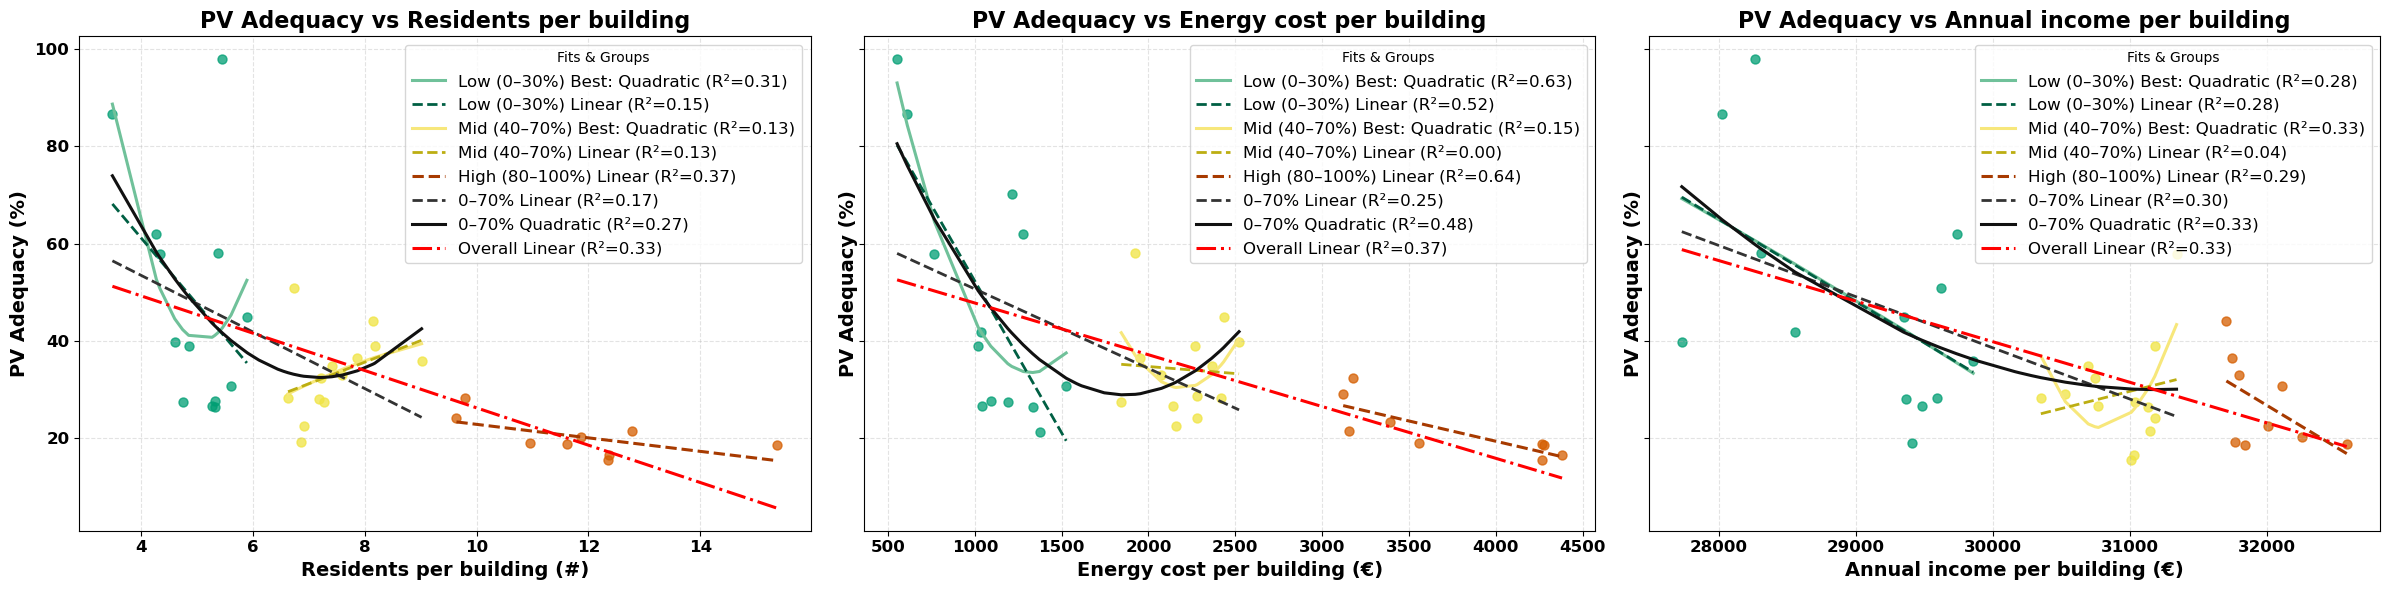


📊 R² summaries per subplot:

— PV Adequacy vs Residents per building —
  Low (0–30%): Linear R²=0.147, Best=Quadratic (R²=0.305)
  Mid (40–70%): Linear R²=0.126, Best=Quadratic (R²=0.128)
  High (80–100%): Linear R²=0.366
  0–70% aggregate: Linear R²=0.169, Quadratic R²=0.272
  Overall Linear (0–100%): R²=0.330

— PV Adequacy vs Energy cost per building —
  Low (0–30%): Linear R²=0.518, Best=Quadratic (R²=0.634)
  Mid (40–70%): Linear R²=0.004, Best=Quadratic (R²=0.151)
  High (80–100%): Linear R²=0.644
  0–70% aggregate: Linear R²=0.247, Quadratic R²=0.479
  Overall Linear (0–100%): R²=0.368

— PV Adequacy vs Annual income per building —
  Low (0–30%): Linear R²=0.277, Best=Quadratic (R²=0.277)
  Mid (40–70%): Linear R²=0.036, Best=Quadratic (R²=0.325)
  High (80–100%): Linear R²=0.285
  0–70% aggregate: Linear R²=0.297, Quadratic R²=0.331
  Overall Linear (0–100%): R²=0.325


In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Helper: R² =====
def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# ===== Colors =====
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}
LINE_COLORS_BEST = {'Low (0–30%)': '#70c19a', 'Mid (40–70%)': '#f7e77b'}
LINE_COLORS_LIN  = {'Low (0–30%)': '#005f43', 'Mid (40–70%)': '#bcae12', 'High (80–100%)': '#a73a00'}

def _bold_ticks(ax, size=12):
    ax.tick_params(axis='both', labelsize=size)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

# ===== Shared plotter (PV Adequacy) =====
def plot_pv_adequacy(ax, df, x_col, x_label, title, legend_fontsize=10):
    y_col = 'PV Adequacy'  # expects values in percent already (0–100)
    y_label = 'PV Adequacy (%)'

    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    if data.empty or len(data) < 3:
        ax.set_title(f"{title}\n(Not enough data)", fontsize=16, fontweight='bold')
        ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.35)
        _bold_ticks(ax, 12)
        return {}

    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)':    (x <= p30),
        'Mid (40–70%)':   (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # Plot per-group
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)
        order  = np.argsort(xg)

        ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=42)

        if "High" not in label:
            # Best among Linear/Log/Exp/Quadratic
            forms = {'Linear': r2_lin}
            y_best = y_lin
            best_form, best_r2 = 'Linear', r2_lin

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                y_log = np.polyval(p, np.log(xg))
                forms['Logarithmic'] = compute_r2(yg, y_log)
            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                y_exp = np.exp(np.polyval(p, xg))
                forms['Exponential'] = compute_r2(yg, y_exp)
            p = np.polyfit(xg, yg, 2)
            y_quad = np.polyval(p, xg)
            forms['Quadratic'] = compute_r2(yg, y_quad)

            best_form = max(forms, key=forms.get)
            best_r2   = forms[best_form]
            if best_form == 'Logarithmic': y_best = y_log
            elif best_form == 'Exponential': y_best = y_exp
            elif best_form == 'Quadratic':  y_best = y_quad

            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.2,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}
        else:
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.2,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # 0–70% combined fits
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70   = np.polyfit(x_70, y_70, 1)
        y_lin_70   = np.polyval(p_lin_70, x_70)
        r2_lin_70  = compute_r2(y_70, y_lin_70)

        p_quad_70  = np.polyfit(x_70, y_70, 2)
        y_quad_70  = np.polyval(p_quad_70, x_70)
        r2_quad_70 = compute_r2(y_70, y_quad_70)

        ord70 = np.argsort(x_70)
        ax.plot(x_70[ord70], y_lin_70[ord70],
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[ord70], y_quad_70[ord70],
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}

    # Overall (0–100%) linear
    p_all  = np.polyfit(x, y, 1)
    y_all  = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    ord_all = np.argsort(x)
    ax.plot(x[ord_all], y_all[ord_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")
    results['_overall'] = r2_all

    # Aesthetics (your requested sizes/weights)
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    _bold_ticks(ax, size=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=12, title_fontsize=10)

    return results


# ===========================
# Build the 1×3 figure
# ===========================
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

panels = [
    # Plot 1
    dict(x_col='Residents per building',
         x_label='Residents per building (#)',
         title='PV Adequacy vs Residents per building'),
    # Plot 2
    dict(x_col='Energy cost per household',
         x_label='Energy cost per building (€)',
         title='PV Adequacy vs Energy cost per building'),
    # Plot 3
    dict(x_col='annual income per household',
         x_label='Annual income per building (€)',
         title='PV Adequacy vs Annual income per building'),
]

summaries = []
for ax, spec in zip(axs, panels):
    res = plot_pv_adequacy(
        ax, merged,
        x_col=spec['x_col'],
        x_label=spec['x_label'],
        title=spec['title'],
        legend_fontsize=10
    )
    summaries.append((spec['title'], res))

plt.tight_layout()
plt.show()

# Optional console summaries
print("\n📊 R² summaries per subplot:")
for title, res in summaries:
    print(f"\n— {title} —")
    if not res:
        print("  Not enough data.")
        continue
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, "
              f"Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")


In [159]:
merged.columns

Index(['fid', 'NAME_x', 'KWD_YPES', 'geometry', 'NAME_y',
       'Περιφερειακή ενότητα', 'buildings', 'Area', 'Pop Dens',
       'PV Production Gwh – Only BBE', 'BBE SC1_100 – Consumption GWh',
       'Adequacy', 'Population', 'Residents per building',
       'Energy consuption per resident Mwh',
       'Energy consumption per household Mwh 4 residents',
       'Consumption Mwh per building', 'Energy cost per residents', 'Average',
       'annual income per household', 'Energy cost per household',
       'Energy Poverty Household', 'Energy Poverty Threshold',
       'Energy_Poverty_Household_s10', 'Energy_Poverty_improvement',
       'poverty_bin', 'Sav_100', 'Sav_10', 'Sav_100_bin', 'PV Adequacy'],
      dtype='object')

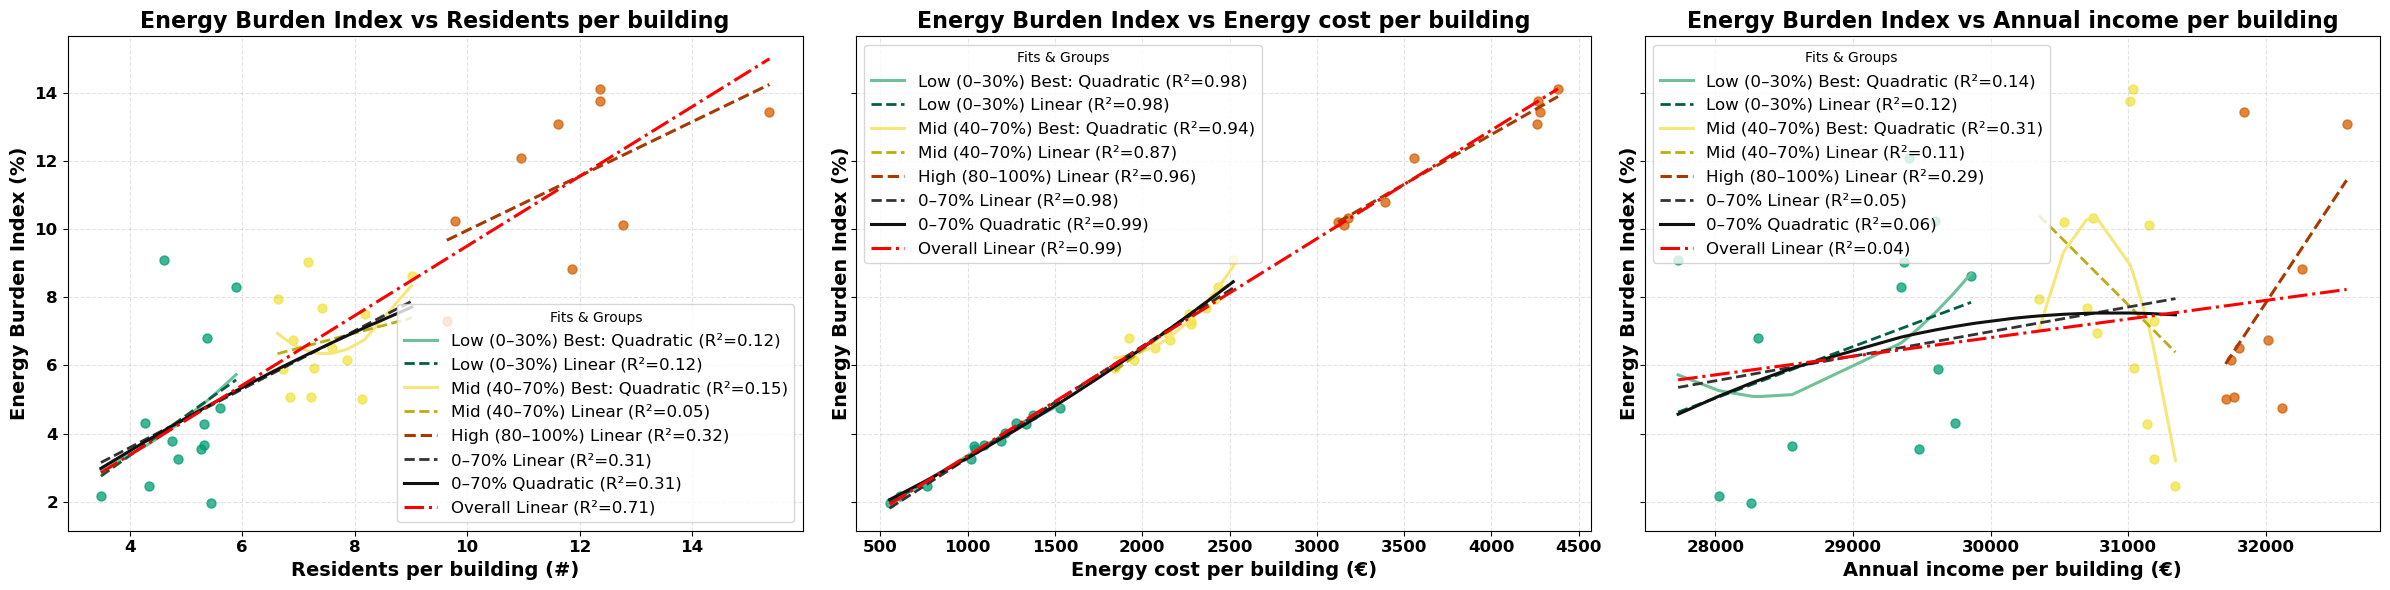


📊 R² summaries per subplot:

— Energy Burden Index vs Residents per building —
  Low (0–30%): Linear R²=0.120, Best=Quadratic (R²=0.121)
  Mid (40–70%): Linear R²=0.050, Best=Quadratic (R²=0.153)
  High (80–100%): Linear R²=0.324
  0–70% aggregate: Linear R²=0.306, Quadratic R²=0.307
  Overall Linear (0–100%): R²=0.705

— Energy Burden Index vs Energy cost per building —
  Low (0–30%): Linear R²=0.983, Best=Quadratic (R²=0.985)
  Mid (40–70%): Linear R²=0.871, Best=Quadratic (R²=0.937)
  High (80–100%): Linear R²=0.964
  0–70% aggregate: Linear R²=0.983, Quadratic R²=0.986
  Overall Linear (0–100%): R²=0.992

— Energy Burden Index vs Annual income per building —
  Low (0–30%): Linear R²=0.116, Best=Quadratic (R²=0.143)
  Mid (40–70%): Linear R²=0.106, Best=Quadratic (R²=0.309)
  High (80–100%): Linear R²=0.286
  0–70% aggregate: Linear R²=0.050, Quadratic R²=0.059
  Overall Linear (0–100%): R²=0.042


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Helper: R² =====
def compute_r2(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# ===== Colors =====
SCATTER_COLORS = {
    'Low (0–30%)':  '#009e73',   # green
    'Mid (40–70%)': '#f0e442',   # yellow
    'High (80–100%)': '#d55e00'  # red
}
LINE_COLORS_BEST = {'Low (0–30%)': '#70c19a', 'Mid (40–70%)': '#f7e77b'}
LINE_COLORS_LIN  = {'Low (0–30%)': '#005f43', 'Mid (40–70%)': '#bcae12', 'High (80–100%)': '#a73a00'}

def _bold_ticks(ax, size=12):
    ax.tick_params(axis='both', labelsize=size)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

# ===== Shared plotter (Energy Poverty Household) =====
def plot_energy_burden(ax, df, x_col, x_label, title, legend_fontsize=10):
    y_col = 'Energy Poverty Household'  # expects values in percent already (0–100)
    y_label = 'Energy Burden Index (%)'

    # Prepare data
    data = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    if data.empty or len(data) < 3:
        ax.set_title(f"{title}\n(Not enough data)", fontsize=16, fontweight='bold')
        ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.35)
        _bold_ticks(ax, 12)
        return {}

    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()

    # Percentiles
    p30, p40, p70, p80 = np.percentile(x, [30, 40, 70, 80])

    # Groups
    groups = {
        'Low (0–30%)':    (x <= p30),
        'Mid (40–70%)':   (x > p40) & (x <= p70),
        'High (80–100%)': (x > p80)
    }

    results = {}

    # Plot per-group
    for label, mask in groups.items():
        xg, yg = x[mask], y[mask]
        if len(xg) < 3:
            continue

        # Linear
        p_lin = np.polyfit(xg, yg, 1)
        y_lin = np.polyval(p_lin, xg)
        r2_lin = compute_r2(yg, y_lin)
        order  = np.argsort(xg)

        ax.scatter(xg, yg, color=SCATTER_COLORS[label], alpha=0.75, s=42)

        if "High" not in label:
            # Best among Linear/Log/Exp/Quadratic
            forms = {'Linear': r2_lin}
            y_best = y_lin
            best_form, best_r2 = 'Linear', r2_lin

            if np.all(xg > 0):
                p = np.polyfit(np.log(xg), yg, 1)
                y_log = np.polyval(p, np.log(xg))
                forms['Logarithmic'] = compute_r2(yg, y_log)
            if np.all(yg > 0):
                p = np.polyfit(xg, np.log(yg), 1)
                y_exp = np.exp(np.polyval(p, xg))
                forms['Exponential'] = compute_r2(yg, y_exp)
            p = np.polyfit(xg, yg, 2)
            y_quad = np.polyval(p, xg)
            forms['Quadratic'] = compute_r2(yg, y_quad)

            best_form = max(forms, key=forms.get)
            best_r2   = forms[best_form]
            if best_form == 'Logarithmic': y_best = y_log
            elif best_form == 'Exponential': y_best = y_exp
            elif best_form == 'Quadratic':  y_best = y_quad

            ax.plot(xg[order], y_best[order],
                    color=LINE_COLORS_BEST[label], linewidth=2.2,
                    label=f"{label} Best: {best_form} (R²={best_r2:.2f})")
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.0,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin, 'Best': (best_form, best_r2)}
        else:
            ax.plot(xg[order], y_lin[order],
                    color=LINE_COLORS_LIN[label], linestyle='--', linewidth=2.2,
                    label=f"{label} Linear (R²={r2_lin:.2f})")
            results[label] = {'Linear': r2_lin}

    # 0–70% combined fits
    mask_0_70 = (x <= p70)
    x_70, y_70 = x[mask_0_70], y[mask_0_70]
    if len(x_70) >= 3:
        p_lin_70   = np.polyfit(x_70, y_70, 1)
        y_lin_70   = np.polyval(p_lin_70, x_70)
        r2_lin_70  = compute_r2(y_70, y_lin_70)

        p_quad_70  = np.polyfit(x_70, y_70, 2)
        y_quad_70  = np.polyval(p_quad_70, x_70)
        r2_quad_70 = compute_r2(y_70, y_quad_70)

        ord70 = np.argsort(x_70)
        ax.plot(x_70[ord70], y_lin_70[ord70],
                color='#333333', linestyle='--', linewidth=2.0,
                label=f"0–70% Linear (R²={r2_lin_70:.2f})")
        ax.plot(x_70[ord70], y_quad_70[ord70],
                color='#111111', linestyle='-', linewidth=2.2,
                label=f"0–70% Quadratic (R²={r2_quad_70:.2f})")

        results['_0_70'] = {'Linear': r2_lin_70, 'Quadratic': r2_quad_70}

    # Overall (0–100%) linear
    p_all  = np.polyfit(x, y, 1)
    y_all  = np.polyval(p_all, x)
    r2_all = compute_r2(y, y_all)
    ord_all = np.argsort(x)
    ax.plot(x[ord_all], y_all[ord_all],
            color='red', linestyle='-.', linewidth=2.2,
            label=f"Overall Linear (R²={r2_all:.2f})")
    results['_overall'] = r2_all

    # Aesthetics (your requested sizes/weights)
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.35)
    _bold_ticks(ax, size=12)
    ax.legend(title='Fits & Groups', frameon=True, fontsize=12, title_fontsize=10)

    return results


# ===========================
# Build the 1×3 figure
# ===========================
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

panels = [
    # Plot 1
    dict(x_col='Residents per building',
         x_label='Residents per building (#)',
         title='Energy Burden Index vs Residents per building'),
    # Plot 2
    dict(x_col='Energy cost per household',
         x_label='Energy cost per building (€)',
         title='Energy Burden Index vs Energy cost per building'),
    # Plot 3
    dict(x_col='annual income per household',
         x_label='Annual income per building (€)',
         title='Energy Burden Index vs Annual income per building'),
]

summaries = []
for ax, spec in zip(axs, panels):
    res = plot_energy_burden(
        ax, merged,
        x_col=spec['x_col'],
        x_label=spec['x_label'],
        title=spec['title'],
        legend_fontsize=10
    )
    summaries.append((spec['title'], res))

plt.tight_layout()
plt.show()

# Optional console summaries
print("\n📊 R² summaries per subplot:")
for title, res in summaries:
    print(f"\n— {title} —")
    if not res:
        print("  Not enough data.")
        continue
    for k, v in res.items():
        if k in ('_overall', '_0_70'):
            continue
        if 'Best' in v:
            print(f"  {k}: Linear R²={v['Linear']:.3f}, Best={v['Best'][0]} (R²={v['Best'][1]:.3f})")
        else:
            print(f"  {k}: Linear R²={v['Linear']:.3f}")
    if '_0_70' in res:
        print(f"  0–70% aggregate: Linear R²={res['_0_70']['Linear']:.3f}, "
              f"Quadratic R²={res['_0_70']['Quadratic']:.3f}")
    if '_overall' in res:
        print(f"  Overall Linear (0–100%): R²={res['_overall']:.3f}")
